In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools', 'sampling_utils')
sys.path.append(api_path)

In [39]:
import numpy as np
import random
import sklearn

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F


from sir_ais_sampling import (run_experiments_gaussians,
                              run_experiments_2_gaussians,
                              sir_correlated_dynamics,
                              sir_independent_dynamics)

from ebm_sampling import (citerais_mala_dynamics,
                          citerais_ula_dynamics,
                          langevin_dynamics,
                          i_ais_z_dynamics,
                          i_ais_v_dynamics,
                          i_ais_b_dynamics)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal,
                           init_independent_normal_scale)

from torch.distributions import (MultivariateNormal, 
                                 Normal, 
                                 Independent, 
                                 Uniform)

from metrics import Evolution
from general_utils import DotDict, send_file_to_remote
#from paths import path_to_save_remote, port_to_remote

# SIR, target = 1 gaussian

In [4]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 10000

In [14]:
N = 10
method_params = {'n_steps': n_steps, 'N': N}
random_seed = 42
method = 'sir_independent' 
mode_init = 'target'
print_results = True
results_independent = run_experiments_gaussians(dim_arr,  
                                                scale_proposal, 
                                                scale_target, 
                                                num_points_in_chain, 
                                                strategy_mean,
                                                device,
                                                batch_size,
                                                method_params,
                                                random_seed,
                                                mode_init,
                                                method,
                                                print_results)

------------------
mode = target
dim = 30
mean estimation of variance = 0.9976082444190979
mean estimation of mean = -0.00036224935320205986
mean estimation of ess = 0.2601260126012601
------
dim = 60
mean estimation of variance = 0.9073191285133362
mean estimation of mean = -0.0065486314706504345
mean estimation of ess = 0.0371037103710371
------
dim = 90
mean estimation of variance = 0.9780464172363281
mean estimation of mean = -0.034617263823747635
mean estimation of ess = 0.012201220122012201
------
dim = 120
mean estimation of variance = 3.985846763754353e-09
mean estimation of mean = 0.05003062263131142
mean estimation of ess = 0.0
------
dim = 150
mean estimation of variance = 4.696149247251924e-09
mean estimation of mean = 0.03965234383940697
mean estimation of ess = 0.0
------
dim = 180
mean estimation of variance = 4.668603725832554e-09
mean estimation of mean = 0.059136275202035904
mean estimation of ess = 0.0
------
dim = 210
mean estimation of variance = 4.7978985229235604

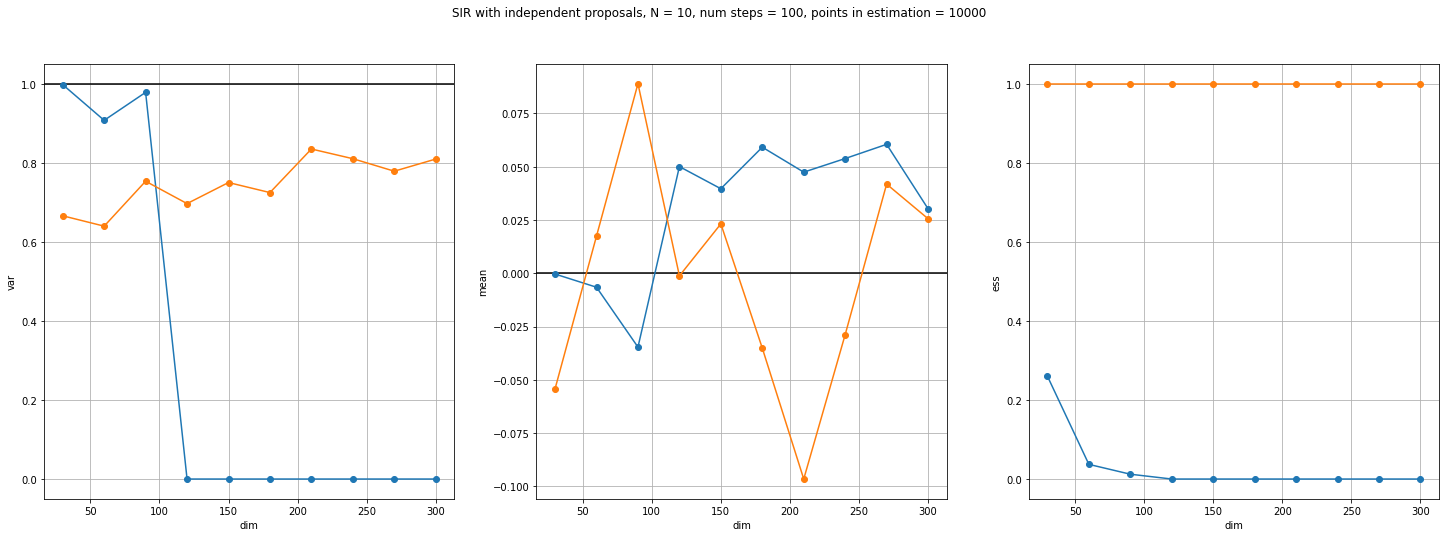

In [26]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(0.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

#axs[2].axhline(0.0, label='real', color='black')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_independent['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_independent['proposal'][mode], label='proposal init', marker='o')
    axs[i].plot(dim_arr, results_independent['target'][mode], marker='o')
    axs[i].plot(dim_arr, results_ais['target'][mode], marker='o')

for ax in axs:
    ax.grid()
    #ax.legend()

plt.show()

Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_independent_1_gaussian.pdf to remote server....


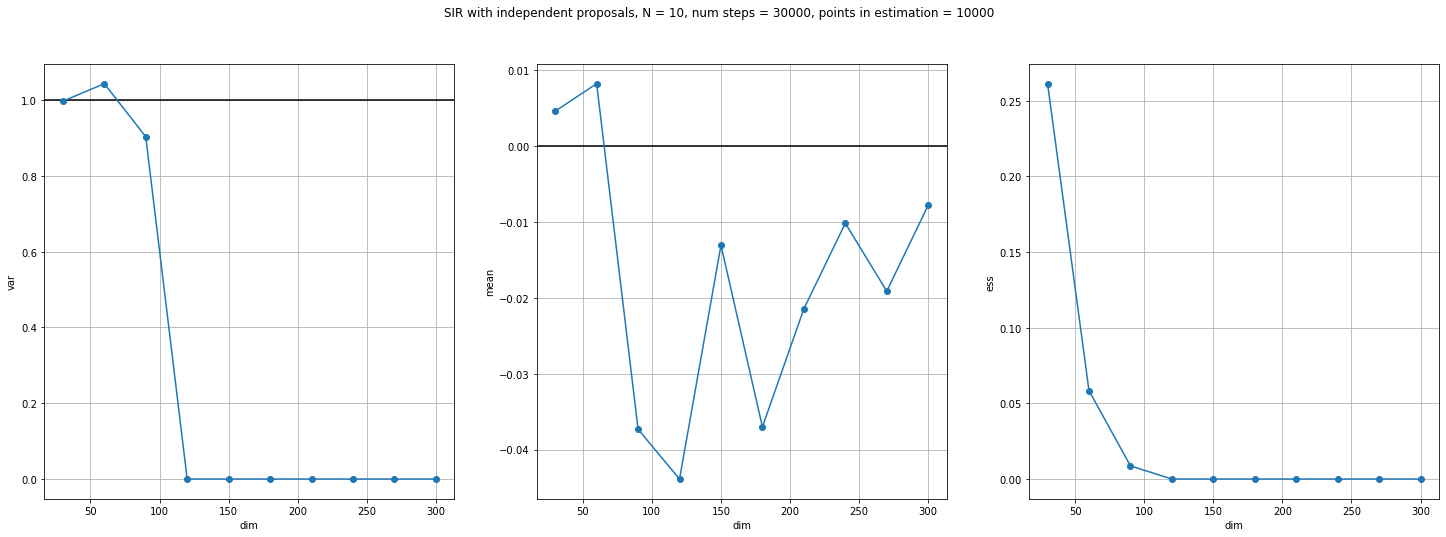

In [78]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(0.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

#axs[2].axhline(0.0, label='real', color='black')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_independent['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_independent['proposal'][mode], label='proposal init', marker='o')
    axs[i].plot(dim_arr, results_independent['target'][mode], marker='o')

for ax in axs:
    ax.grid()
    #ax.legend()

path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_independent_1_gaussian.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote)
plt.show()

In [16]:
# fig, axs = plt.subplots(ncols=2, nrows=len(dim_arr), figsize=(15, 55))
# name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
# fig.suptitle(name)

# for i, dim in enumerate(dim_arr):
#     axs[i][0].set_xlabel('MC iter')
#     axs[i][0].set_ylabel('first coord of sample')
#     #axs[i][0].plot(np.arange(len(dict_results['target']['history_first'][i])), 
#     #               dict_results['target']['history_first'][i], 
#     #               label=f'target init', marker='o')
#     axs[i][0].plot(np.arange(len(results_independent['proposal']['history_first'][i])), 
#                    results_independent['proposal']['history_first'][i], 
#                    label=f'proposal init', marker='o')
#     axs[i][0].set_title(f'dim = {dim}')
#     axs[i][0].grid()
#     axs[i][0].legend()

#     axs[i][1].set_xlabel('MC iter')
#     axs[i][1].set_ylabel('norm of sample')
#     #axs[i][1].plot(np.arange(len(dict_results['target']['history_norm'][i])), 
#     #               dict_results['target']['history_norm'][i], 
#     #               label='target init', marker='o')
#     axs[i][1].plot(np.arange(len(results_independent['proposal']['history_norm'][i])), 
#                    results_independent['proposal']['history_norm'][i], 
#                    label=f'proposal init', marker='o')
#     axs[i][1].set_title(f'dim = {dim}')
#     axs[i][1].grid()
#     axs[i][1].legend()


# plt.show()    

In [5]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
print_results = True
mode_init = 'proposal'
results_corr = run_experiments_gaussians(dim_arr,  
                                         scale_proposal, 
                                         scale_target, 
                                         num_points_in_chain, 
                                         strategy_mean,
                                         device,
                                         batch_size,
                                         method_params,
                                         random_seed,
                                         mode_init,
                                         method,
                                         print_results)

------------------
mode = proposal
dim = 30
mean estimation of variance = 1.0070724487304688
mean estimation of mean = -0.017963342368602753
mean estimation of ess = 0.849084908490849
------
dim = 60
mean estimation of variance = 0.9941338300704956
mean estimation of mean = -0.015106490813195705
mean estimation of ess = 0.8454845484548454
------
dim = 90
mean estimation of variance = 0.9752694964408875
mean estimation of mean = -0.030947521328926086
mean estimation of ess = 0.847084708470847
------
dim = 120
mean estimation of variance = 0.9907028079032898
mean estimation of mean = -0.012816584669053555
mean estimation of ess = 0.8453845384538454
------
dim = 150
mean estimation of variance = 0.9856138229370117
mean estimation of mean = -0.019321436062455177
mean estimation of ess = 0.8432843284328433
------
dim = 180
mean estimation of variance = 0.9703444838523865
mean estimation of mean = -0.028816070407629013
mean estimation of ess = 0.8481848184818482
------
dim = 210
mean estimat

Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_1_gaussian.pdf to remote server....


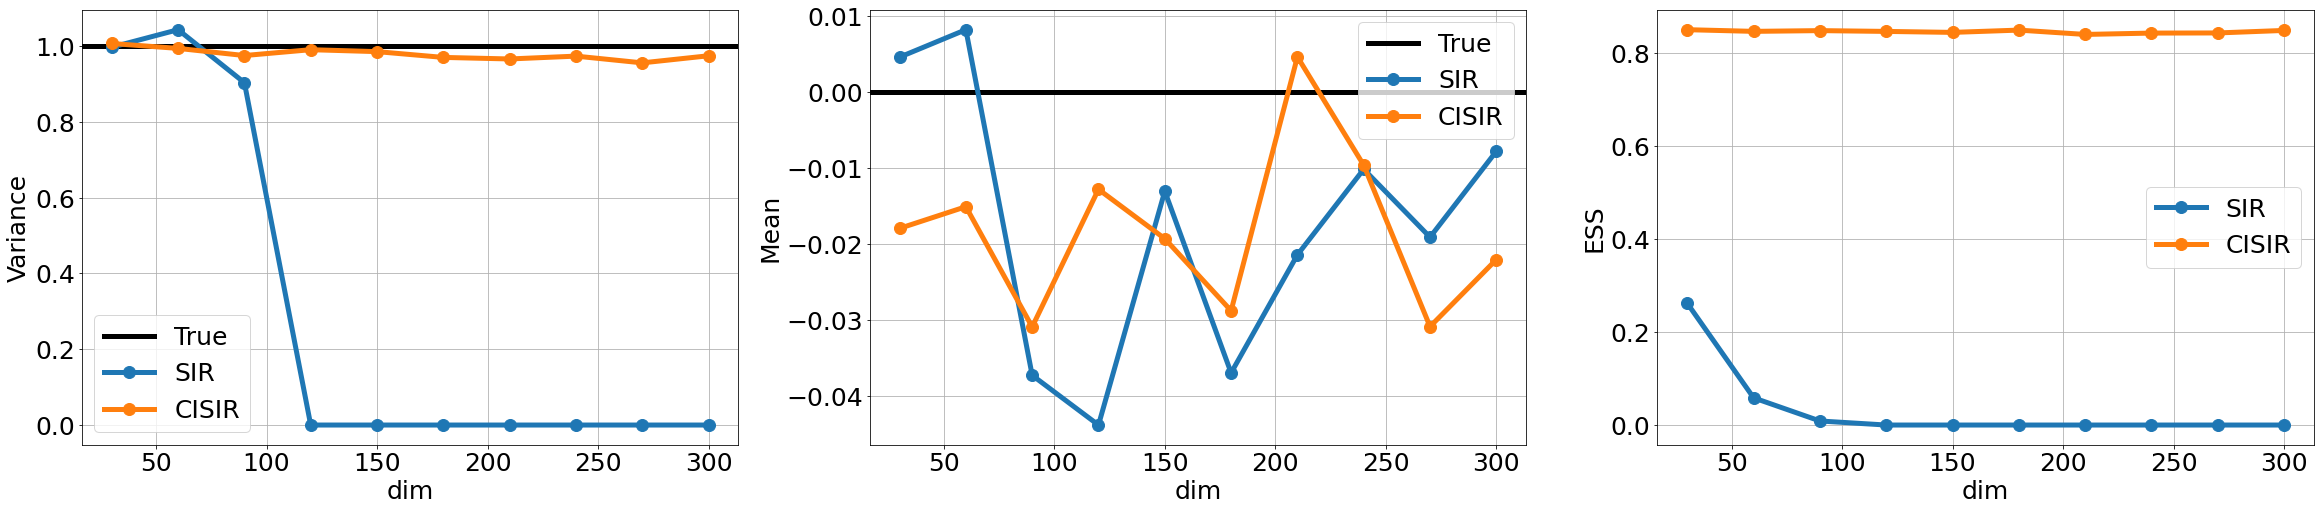

In [51]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})
linewidth = 5
markersize = 12

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(40, 8))
#name = f'SIR, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}'
#fig.suptitle(name)

axs[0].axhline(var_target, label='True', color='black', linewidth = linewidth)
axs[0].set_xlabel('dim')
axs[0].set_ylabel('Variance')

axs[1].axhline(0.0, label='True', color='black', linewidth = linewidth)
axs[1].set_xlabel('dim')
axs[1].set_ylabel('Mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_corr['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_corr['proposal'][mode], label='proposal init', marker='o')
    axs[i].plot(dim_arr, results_independent['target'][mode], label = 'SIR', marker='o',
                markersize = markersize,
                linewidth = linewidth)
    axs[i].plot(dim_arr_corr[:10], results_corr['proposal'][mode][:10], label = 'CISIR', marker='o',
                markersize = markersize,
               linewidth = linewidth)

for ax in axs:
    ax.grid()
    ax.legend()

path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_1_gaussian.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote)    

plt.show()

In [ ]:
# fig, axs = plt.subplots(ncols=2, nrows=len(dim_arr), figsize=(15, 75))
# name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}'
# fig.suptitle(name)

# for i, dim in enumerate(dim_arr):
#     axs[i][0].set_xlabel('MC iter')
#     axs[i][0].set_ylabel('first coord of sample')
#     axs[i][0].plot(np.arange(len(results_corr['proposal']['history_first'][i])), 
#                    results_corr['proposal']['history_first'][i], 
#                    label=f'proposal init', marker='o')
#     axs[i][0].set_title(f'dim = {dim}')
#     axs[i][0].grid()
#     axs[i][0].legend()

#     axs[i][1].set_xlabel('MC iter')
#     axs[i][1].set_ylabel('norm of sample')
#     axs[i][1].plot(np.arange(len(results_corr['proposal']['history_norm'][i])), 
#                    results_corr['proposal']['history_norm'][i], 
#                    label='proposal init', marker='o')
#     axs[i][1].set_title(f'dim = {dim}')
#     axs[i][1].grid()
#     axs[i][1].legend()


# plt.show()    

In [81]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 1.0
var_target = 2.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 50000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
print_results = True
mode_init = 'proposal'
results_add = run_experiments_gaussians(dim_arr,  
                                         scale_proposal, 
                                         scale_target, 
                                         num_points_in_chain, 
                                         strategy_mean,
                                         device,
                                         batch_size,
                                         method_params,
                                         random_seed,
                                         mode_init,
                                         method,
                                         print_results)

------------------
mode = proposal
dim = 30
mean estimation of variance = 1.9679615497589111
mean estimation of mean = -0.013693430460989475
mean estimation of ess = 0.8473747374737475
------
dim = 60
mean estimation of variance = 1.9376026391983032
mean estimation of mean = 0.0024218917824327946
mean estimation of ess = 0.8488548854885488
------
dim = 90
mean estimation of variance = 1.9066861867904663
mean estimation of mean = 0.007491488475352526
mean estimation of ess = 0.8501650165016501
------
dim = 120
mean estimation of variance = 1.8742953538894653
mean estimation of mean = 0.0036861300468444824
mean estimation of ess = 0.8490849084908489
------
dim = 150
mean estimation of variance = 1.8474078178405762
mean estimation of mean = 0.007857578806579113
mean estimation of ess = 0.8500550055005501
------
dim = 180
mean estimation of variance = 1.8296598196029663
mean estimation of mean = 0.004962598904967308
mean estimation of ess = 0.8501350135013501
------
dim = 210
mean estimati

# SIR, target = 2 gaussians

In [69]:
%autoreload 2

In [6]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_1_target = 1.0
loc_2_target = -1.0

num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
mode_init = 'proposal'
print_results = True
results_corr_2 = run_experiments_2_gaussians(dim_arr,  
                                             scale_proposal, 
                                             scale_target,
                                             loc_1_target,
                                             loc_2_target,
                                             num_points_in_chain, 
                                             strategy_mean,
                                             device,
                                             batch_size,
                                             method_params,
                                             random_seed,
                                             mode_init,
                                             method,
                                             print_results)

------------------
mode = proposal
dim = 30
mean estimation of target variance = 0.9649330345694039
mean estimation of 1 mode mean  = 1.001739740371704
mean estimation of 2 mode mean  = -1.0066263675689697
mean estimation of JSD  = 0.035398959368467334
mean estimation of HQR  = 0.9492499947547912
mean estimation of ESS = 0.7905590559055906
------
dim = 60
mean estimation of target variance = 0.9684273057532629
mean estimation of 1 mode mean  = 0.997853696346283
mean estimation of 2 mode mean  = -1.0056425333023071
mean estimation of JSD  = 0.03554243594408035
mean estimation of HQR  = 0.9503100037574768
mean estimation of ESS = 0.7908890889088909
------
dim = 90
mean estimation of target variance = 0.9752672240779294
mean estimation of 1 mode mean  = 0.9903038740158081
mean estimation of 2 mode mean  = -1.0032496452331543
mean estimation of JSD  = 0.03547200188040733
mean estimation of HQR  = 0.9497600018978118
mean estimation of ESS = 0.7934193419341935
------
dim = 120
mean estimatio

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_correlated_2_gaussians.pdf to remote server....


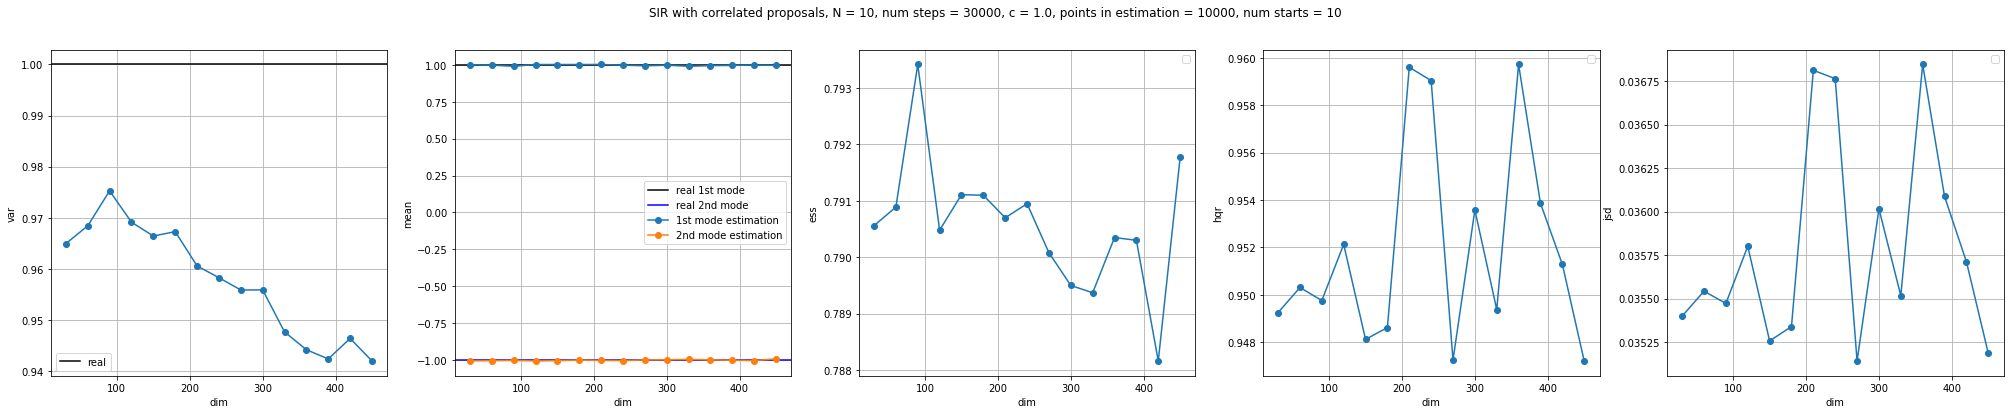

In [71]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(35, 6))
name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}, num starts = {batch_size}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(loc_1_target, label='real 1st mode', color='black')
axs[1].axhline(loc_2_target, label='real 2nd mode', color='blue')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

axs[3].set_xlabel('dim')
axs[3].set_ylabel('hqr')

axs[4].set_xlabel('dim')
axs[4].set_ylabel('jsd')

modes_to_plot = ['mean_var', 'mean_loc_1', 'mean_loc_2', 'ess', 'mean_hqr', 'mean_jsd']
for i, mode in enumerate(modes_to_plot):
    if i == 1:
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_1'], 
        #            label='target init, 1st mode estimation', marker='o')
        axs[i].plot(dim_arr, results_corr_2['proposal']['mean_loc_1'], 
                    label='1st mode estimation', marker='o')
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_2'], 
        #            label='target init, 2nd mode estimation', marker='o')
        axs[i].plot(dim_arr, results_corr_2['proposal']['mean_loc_2'], 
                    label='2nd mode estimation', marker='o')
    elif i == 2:
        pass
    else:
        if i == 0:
            j = 0
        else:
            j = i - 1
        #axs[j].plot(dim_arr, results_corr['target'][mode], label='target init', marker='o')
        axs[j].plot(dim_arr, results_corr_2['proposal'][mode], marker='o')
    
for ax in axs:
    ax.grid()
    ax.legend()
    
path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_correlated_2_gaussians.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote) 

plt.show()

In [7]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_1_target = 1.0
loc_2_target = -1.0

num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_independent' 
mode_init = 'target'
print_results = True
results_independent_2 = run_experiments_2_gaussians(dim_arr,  
                                                    scale_proposal, 
                                                    scale_target,
                                                    loc_1_target,
                                                    loc_2_target,
                                                    num_points_in_chain, 
                                                    strategy_mean,
                                                    device,
                                                    batch_size,
                                                    method_params,
                                                    random_seed,
                                                    mode_init,
                                                    method,
                                                    print_results)

------------------
mode = target
dim = 30
mean estimation of target variance = 0.5177300910103673
mean estimation of 1 mode mean  = 0.8630160093307495
mean estimation of 2 mode mean  = -0.8818822503089905
mean estimation of JSD  = 0.044360130093991756
mean estimation of HQR  = 0.9425499975681305
mean estimation of ESS = 0.0037703770377037703
------
dim = 60
mean estimation of target variance = 7.373292264391776e-14
mean estimation of 1 mode mean  = 0.9944514036178589
mean estimation of 2 mode mean  = -1.0214898586273193
mean estimation of JSD  = 0.04247488081455231
mean estimation of HQR  = 1.0
mean estimation of ESS = 0.0
------
dim = 90
mean estimation of target variance = 7.426876359800128e-14
mean estimation of 1 mode mean  = 1.01462721824646
mean estimation of 2 mode mean  = -0.9778567552566528
mean estimation of JSD  = 0.04247488081455231
mean estimation of HQR  = 1.0
mean estimation of ESS = 0.0
------
dim = 120
mean estimation of target variance = 7.118772735836129e-14
mean est

In [9]:
dim_arr_corr = [30*(i + 1) for i in range(15)]

Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_2_gaussians.pdf to remote server....


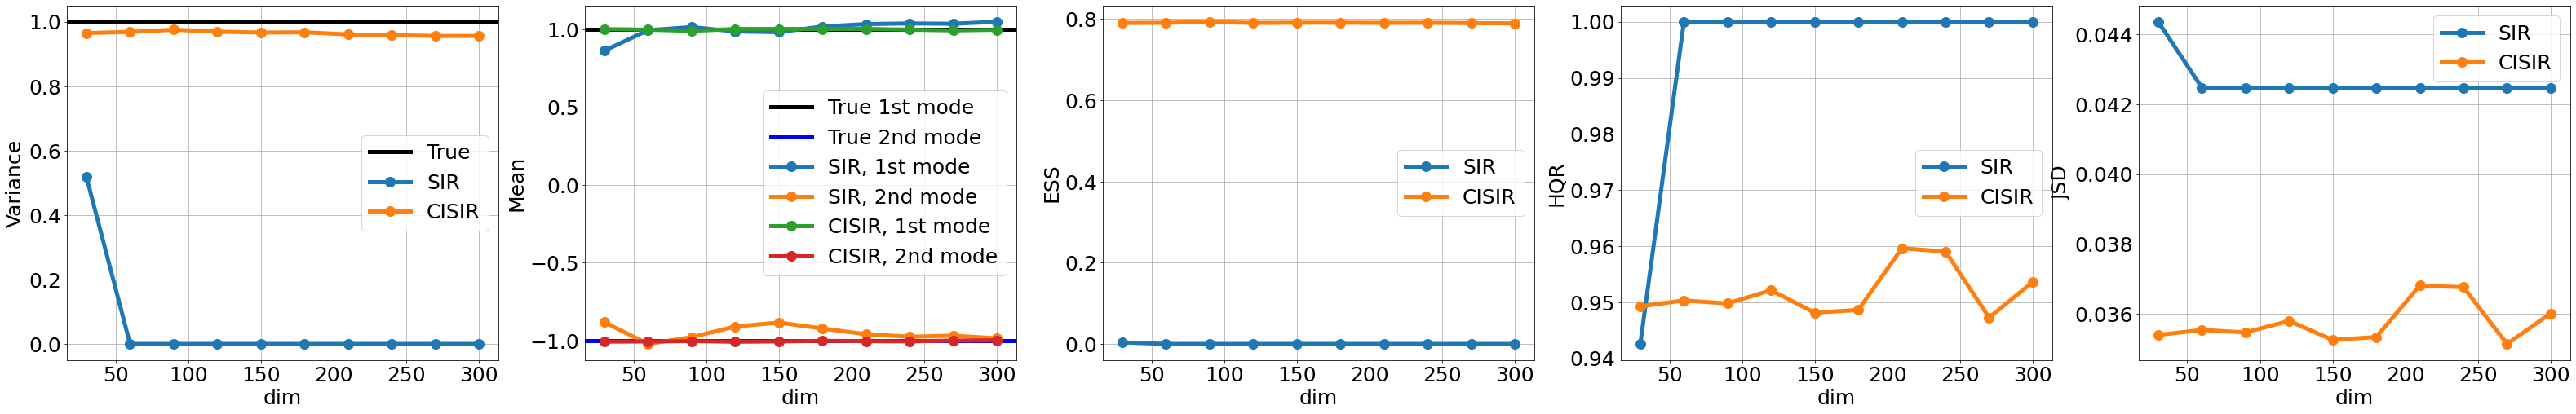

In [50]:
plt.rcParams.update({'font.size': 25})
linewidth = 5
markersize = 12

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(55, 8))
#name = f'SIR, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}, num starts = {batch_size}'
#fig.suptitle(name)

axs[0].axhline(var_target, label='True', color='black', linewidth = linewidth)
axs[0].set_xlabel('dim')
axs[0].set_ylabel('Variance')

axs[1].axhline(loc_1_target, label='True 1st mode', color='black', linewidth = linewidth)
axs[1].axhline(loc_2_target, label='True 2nd mode', color='blue', linewidth = linewidth)
axs[1].set_xlabel('dim')
axs[1].set_ylabel('Mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS')

axs[3].set_xlabel('dim')
axs[3].set_ylabel('HQR')

axs[4].set_xlabel('dim')
axs[4].set_ylabel('JSD')

modes_to_plot = ['mean_var', 'mean_loc_1', 'mean_loc_2', 'ess', 'mean_hqr', 'mean_jsd']
for i, mode in enumerate(modes_to_plot):
    if i == 1:
        axs[i].plot(dim_arr, results_independent_2['target']['mean_loc_1'], 
                    label='SIR, 1st mode', marker='o', linewidth = linewidth, 
                   markersize = markersize )
        axs[i].plot(dim_arr, results_independent_2['target']['mean_loc_2'], 
                    label='SIR, 2nd mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        axs[i].plot(dim_arr_corr[:10], results_corr_2['proposal']['mean_loc_1'][:10], 
                    label='CISIR, 1st mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_2'], 
        #            label='target init, 2nd mode estimation', marker='o')
        axs[i].plot(dim_arr_corr[:10], results_corr_2['proposal']['mean_loc_2'][:10], 
                    label='CISIR, 2nd mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
    elif i == 2:
        pass
    else:
        if i == 0:
            j = 0
        else:
            j = i - 1
        axs[j].plot(dim_arr, results_independent_2['target'][mode], 
                    label='SIR', marker='o', linewidth = linewidth,
                   markersize  = markersize)
        axs[j].plot(dim_arr_corr[:10], results_corr_2['proposal'][mode][:10], 
                    label='CISIR', marker='o', linewidth = linewidth,
                   markersize  = markersize)
    
for ax in axs:
    ax.grid()
    ax.legend()
    
path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_2_gaussians.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote) 

plt.show()

# AIS

In [98]:
dim_arr = [2] + [30*(i + 1) for i in range(9)]  

loc_target = 3.0
loc_proposal = 0.0

var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 100
strategy_mean = 'starts' #'chain'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
batch_size = 100
n_steps = 1000 #5000

In [99]:
N = 10

T = 100
betas = np.linspace(1., 0., T)

grad_step = 0.5
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale, 
                 'betas': betas}
random_seed = 42
method = 'i_ais_z' 
mode_init = 'proposal'
print_results = True

results_ais_z = run_experiments_gaussians(dim_arr,  
                                          scale_proposal, 
                                          scale_target, 
                                          loc_target,
                                          num_points_in_chain, 
                                          strategy_mean,
                                          device,
                                          batch_size,
                                          method_params,
                                          random_seed = random_seed,
                                          loc_proposal = loc_proposal,
                                          mode_init = mode_init,
                                          method = method,
                                          print_results = print_results) 

  0%|          | 1/1000 [00:00<02:48,  5.93it/s]

------------------
mode = proposal
dim = 2


  0%|          | 1/1000 [00:00<02:44,  6.09it/s]

mean estimation of acceptence rate = 0.9506688714027405
mean estimation of variance = 0.9799764156341553
mean estimation of mean = 2.987982749938965
mean estimation of ess = 1.0
------
dim = 30


  0%|          | 1/1000 [00:00<02:41,  6.19it/s]

mean estimation of acceptence rate = 0.8086444735527039
mean estimation of variance = 1.0251572132110596
mean estimation of mean = 3.001560926437378
mean estimation of ess = 1.0
------
dim = 60


  0%|          | 1/1000 [00:00<02:37,  6.32it/s]

mean estimation of acceptence rate = 0.7525371313095093
mean estimation of variance = 1.0533504486083984
mean estimation of mean = 3.0011706352233887
mean estimation of ess = 1.0
------
dim = 90


  0%|          | 1/1000 [00:00<02:45,  6.03it/s]

mean estimation of acceptence rate = 0.7206325531005859
mean estimation of variance = 1.0782086849212646
mean estimation of mean = 3.00019907951355
mean estimation of ess = 1.0
------
dim = 120


  0%|          | 1/1000 [00:00<02:38,  6.31it/s]

mean estimation of acceptence rate = 0.7005617618560791
mean estimation of variance = 1.1021840572357178
mean estimation of mean = 3.002284049987793
mean estimation of ess = 1.0
------
dim = 150


  0%|          | 1/1000 [00:00<02:43,  6.11it/s]

mean estimation of acceptence rate = 0.6870773434638977
mean estimation of variance = 1.1247587203979492
mean estimation of mean = 2.999558210372925
mean estimation of ess = 1.0
------
dim = 180


  0%|          | 1/1000 [00:00<02:44,  6.09it/s]

mean estimation of acceptence rate = 0.6777768731117249
mean estimation of variance = 1.1406363248825073
mean estimation of mean = 3.0007872581481934
mean estimation of ess = 1.0
------
dim = 210


  0%|          | 1/1000 [00:00<02:44,  6.06it/s]

mean estimation of acceptence rate = 0.671162486076355
mean estimation of variance = 1.15532386302948
mean estimation of mean = 3.0004806518554688
mean estimation of ess = 1.0
------
dim = 240


  0%|          | 1/1000 [00:00<02:36,  6.36it/s]

mean estimation of acceptence rate = 0.6665022373199463
mean estimation of variance = 1.169166922569275
mean estimation of mean = 3.000033140182495
mean estimation of ess = 1.0
------
dim = 270


100%|██████████| 1000/1000 [02:38<00:00,  6.30it/s]


mean estimation of acceptence rate = 0.6630469560623169
mean estimation of variance = 1.1794703006744385
mean estimation of mean = 3.0000674724578857
mean estimation of ess = 1.0
------


In [101]:
N = 10

T = 100
betas = np.linspace(1., 0., T)

grad_step = 1e-1
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale, 
                 'betas': betas}
random_seed = 42
method = 'i_ais_z' 
mode_init = 'proposal'
print_results = True

results_ais_z = run_experiments_gaussians(dim_arr,  
                                          scale_proposal, 
                                          scale_target, 
                                          loc_target,
                                          num_points_in_chain, 
                                          strategy_mean,
                                          device,
                                          batch_size,
                                          method_params,
                                          random_seed = random_seed,
                                          loc_proposal = loc_proposal,
                                          mode_init = mode_init,
                                          method = method,
                                          print_results = print_results) 

  0%|          | 1/1000 [00:00<02:39,  6.25it/s]

------------------
mode = proposal
dim = 2


  0%|          | 1/1000 [00:00<02:42,  6.14it/s]

mean estimation of acceptence rate = 0.9956016540527344
mean estimation of variance = 1.0094916820526123
mean estimation of mean = 2.9952008724212646
mean estimation of ess = 1.0
------
dim = 30


  0%|          | 1/1000 [00:00<02:42,  6.16it/s]

mean estimation of acceptence rate = 0.9826899170875549
mean estimation of variance = 1.0394936800003052
mean estimation of mean = 3.0001168251037598
mean estimation of ess = 1.0
------
dim = 60


  0%|          | 1/1000 [00:00<02:38,  6.29it/s]

mean estimation of acceptence rate = 0.9771558046340942
mean estimation of variance = 1.0508629083633423
mean estimation of mean = 3.001079797744751
mean estimation of ess = 1.0
------
dim = 90


  0%|          | 1/1000 [00:00<02:35,  6.43it/s]

mean estimation of acceptence rate = 0.9735724329948425
mean estimation of variance = 1.053709864616394
mean estimation of mean = 2.9998722076416016
mean estimation of ess = 1.0
------
dim = 120


  0%|          | 1/1000 [00:00<02:40,  6.21it/s]

mean estimation of acceptence rate = 0.9708898663520813
mean estimation of variance = 1.0589863061904907
mean estimation of mean = 2.9990451335906982
mean estimation of ess = 1.0
------
dim = 150


  0%|          | 1/1000 [00:00<02:39,  6.25it/s]

mean estimation of acceptence rate = 0.9688553810119629
mean estimation of variance = 1.0632952451705933
mean estimation of mean = 2.9990553855895996
mean estimation of ess = 1.0
------
dim = 180


  0%|          | 1/1000 [00:00<02:38,  6.31it/s]

mean estimation of acceptence rate = 0.9671934247016907
mean estimation of variance = 1.0636357069015503
mean estimation of mean = 2.9995696544647217
mean estimation of ess = 1.0
------
dim = 210


  0%|          | 1/1000 [00:00<02:45,  6.04it/s]

mean estimation of acceptence rate = 0.9657918214797974
mean estimation of variance = 1.0665677785873413
mean estimation of mean = 3.0000147819519043
mean estimation of ess = 1.0
------
dim = 240


  0%|          | 1/1000 [00:00<02:45,  6.05it/s]

mean estimation of acceptence rate = 0.9646837115287781
mean estimation of variance = 1.0686955451965332
mean estimation of mean = 2.999887704849243
mean estimation of ess = 1.0
------
dim = 270


100%|██████████| 1000/1000 [02:41<00:00,  6.21it/s]


mean estimation of acceptence rate = 0.9636994004249573
mean estimation of variance = 1.0710464715957642
mean estimation of mean = 2.999701976776123
mean estimation of ess = 1.0
------


In [103]:
N = 10

T = 100
betas = np.linspace(1., 0., T)

grad_step = 1e-1
eps_scale = (2*grad_step)**0.5

rho = 1.0
method_params = {'n_steps': n_steps, 
                 'N': N, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale, 
                 'betas': betas,
                 'rho': rho}
random_seed = 42
method = 'i_ais_v' 
mode_init = 'proposal'
print_results = True

results_ais_v = run_experiments_gaussians(dim_arr,  
                                          scale_proposal, 
                                          scale_target, 
                                          loc_target,
                                          num_points_in_chain, 
                                          strategy_mean,
                                          device,
                                          batch_size,
                                          method_params,
                                          random_seed = random_seed,
                                          loc_proposal = loc_proposal,
                                          mode_init = mode_init,
                                          method = method,
                                          print_results = print_results) 

  0%|          | 1/1000 [00:00<02:40,  6.23it/s]

------------------
mode = proposal
dim = 2


  0%|          | 1/1000 [00:00<02:44,  6.07it/s]

mean estimation of acceptence rate = 0.9954167604446411
mean estimation of variance = 1.0138804912567139
mean estimation of mean = 3.003115653991699
mean estimation of ess = 1.0
------
dim = 30


  0%|          | 1/1000 [00:00<02:39,  6.27it/s]

mean estimation of acceptence rate = 0.9839482307434082
mean estimation of variance = 1.0501848459243774
mean estimation of mean = 2.9868385791778564
mean estimation of ess = 1.0
------
dim = 60


  0%|          | 1/1000 [00:00<02:39,  6.26it/s]

mean estimation of acceptence rate = 0.9800238609313965
mean estimation of variance = 1.057953953742981
mean estimation of mean = 2.984686851501465
mean estimation of ess = 1.0
------
dim = 90


  0%|          | 1/1000 [00:00<02:35,  6.43it/s]

mean estimation of acceptence rate = 0.9777852296829224
mean estimation of variance = 1.0659527778625488
mean estimation of mean = 2.9823639392852783
mean estimation of ess = 1.0
------
dim = 120


  0%|          | 1/1000 [00:00<02:45,  6.02it/s]

mean estimation of acceptence rate = 0.9764028787612915
mean estimation of variance = 1.0708767175674438
mean estimation of mean = 2.981959104537964
mean estimation of ess = 1.0
------
dim = 150


  0%|          | 1/1000 [00:00<02:48,  5.94it/s]

mean estimation of acceptence rate = 0.9754036664962769
mean estimation of variance = 1.0692031383514404
mean estimation of mean = 2.981412410736084
mean estimation of ess = 1.0
------
dim = 180


  0%|          | 1/1000 [00:00<02:41,  6.20it/s]

mean estimation of acceptence rate = 0.9746785163879395
mean estimation of variance = 1.0749632120132446
mean estimation of mean = 2.9822604656219482
mean estimation of ess = 1.0
------
dim = 210


  0%|          | 1/1000 [00:00<02:40,  6.23it/s]

mean estimation of acceptence rate = 0.974176287651062
mean estimation of variance = 1.0732409954071045
mean estimation of mean = 2.981896162033081
mean estimation of ess = 1.0
------
dim = 240


  0%|          | 1/1000 [00:00<02:44,  6.09it/s]

mean estimation of acceptence rate = 0.9737826585769653
mean estimation of variance = 1.07517671585083
mean estimation of mean = 2.980494737625122
mean estimation of ess = 1.0
------
dim = 270


100%|██████████| 1000/1000 [02:41<00:00,  6.17it/s]


mean estimation of acceptence rate = 0.973441481590271
mean estimation of variance = 1.0759360790252686
mean estimation of mean = 2.9804859161376953
mean estimation of ess = 1.0
------


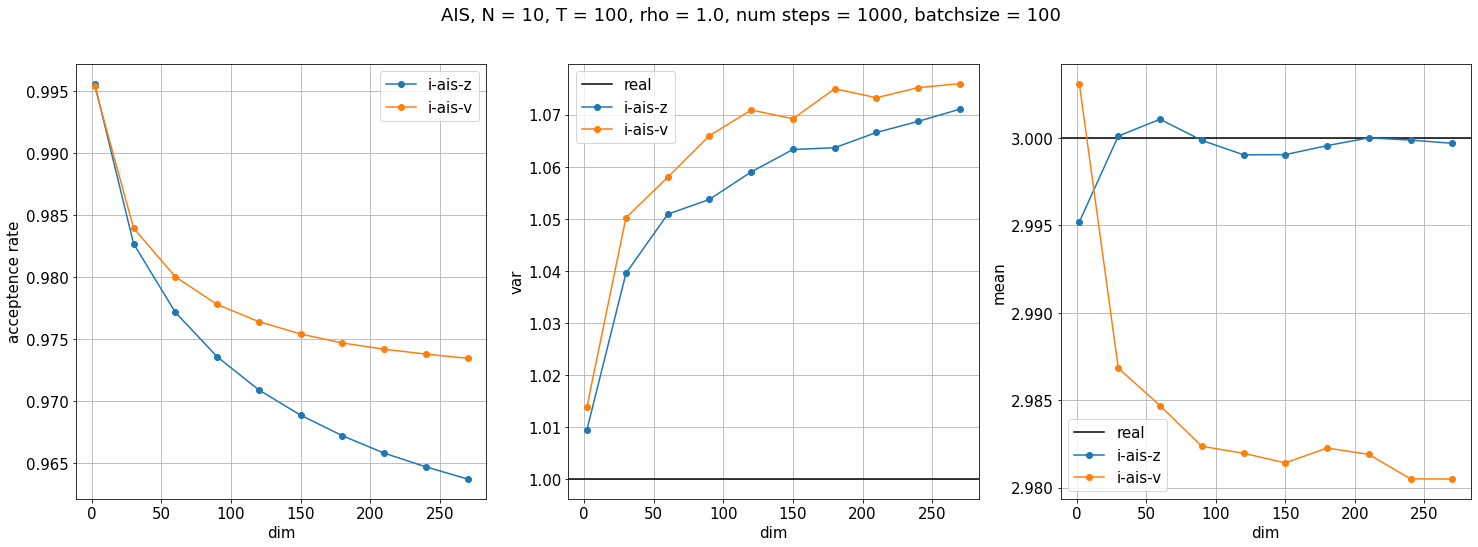

In [104]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'AIS, N = {N}, T = {T}, rho = {rho}, num steps = {n_steps}, batchsize = {batch_size}'
fig.suptitle(name)

axs[0].set_xlabel('dim')
axs[0].set_ylabel('acceptence rate')

axs[1].axhline(1.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('var')

axs[2].axhline(3.0, label='real', color='black')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('mean')

#axs[2].axhline(0.0, label='real', color='black')
#axs[3].set_xlabel('dim')
#axs[3].set_ylabel('ess')

modes_to_plot = ['acceptence', 'mean_var', 'mean_loc']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_independent['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_independent['proposal'][mode], label='proposal init', marker='o')
    #axs[i].plot(dim_arr, results_independent['target'][mode], marker='o')
    # axs[i].plot(dim_arr, results_ais['proposal'][mode], marker='o', label='ais')
    axs[i].plot(dim_arr, results_ais_z['proposal'][mode], marker='o', label='i-ais-z')
    axs[i].plot(dim_arr, results_ais_v['proposal'][mode], marker='o', label='i-ais-v')
    #axs[i].plot(dim_arr, results_ais_b['proposal'][mode], marker='o', label='i-ais-b')
    # axs[i].plot(dim_arr, results_cais['proposal'][mode], marker='o', label='cais')

for ax in axs:
    ax.grid()
    ax.legend()

#plt.savefig('../../fig.png')
plt.show()

In [9]:
N = 10

T = 50
betas = np.linspace(1., 0., T)

grad_step = 0.5
eps_scale = (2*grad_step)**0.5

rho = 1.0
method_params = {'n_steps': n_steps, 
                 'N': N, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale, 
                 'betas': betas,
                 'rho': rho}
random_seed = 42
method = 'i_ais_z' 
mode_init = 'proposal'
print_results = True

results_ais_z = run_experiments_gaussians(dim_arr,  
                                          scale_proposal, 
                                          scale_target, 
                                          loc_target,
                                          num_points_in_chain, 
                                          strategy_mean,
                                          device,
                                          batch_size,
                                          method_params,
                                          random_seed = random_seed,
                                          loc_proposal = loc_proposal,
                                          mode_init = mode_init,
                                          method = method,
                                          print_results = print_results) 

------------------
mode = proposal
dim = 2
mean estimation of acceptence rate = 0.9511834979057312
mean estimation of variance = 0.9995646476745605
mean estimation of mean = 3.011035203933716
mean estimation of ess = 1.0
------
dim = 30
mean estimation of acceptence rate = 0.8246269226074219
mean estimation of variance = 1.0486921072006226
mean estimation of mean = 3.000185251235962
mean estimation of ess = 1.0
------
dim = 60
mean estimation of acceptence rate = 0.7842567563056946
mean estimation of variance = 1.0950356721878052
mean estimation of mean = 3.000074625015259
mean estimation of ess = 1.0
------
dim = 90
mean estimation of acceptence rate = 0.7651194334030151
mean estimation of variance = 1.1314855813980103
mean estimation of mean = 3.0001535415649414
mean estimation of ess = 1.0
------
dim = 120
mean estimation of acceptence rate = 0.7548710703849792
mean estimation of variance = 1.1580870151519775
mean estimation of mean = 2.999005079269409
mean estimation of ess = 1.0
-

In [10]:
N = 10

T = 50
betas = np.linspace(1., 0., T)

grad_step = 0.5
eps_scale = (2*grad_step)**0.5

rho = 1.0
method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_v' 
mode_init = 'proposal'
print_results = True

results_ais_v = run_experiments_gaussians(dim_arr,  
                                          scale_proposal, 
                                          scale_target, 
                                          loc_target,
                                          num_points_in_chain, 
                                          strategy_mean,
                                          device,
                                          batch_size,
                                          method_params,
                                          random_seed = random_seed,
                                          loc_proposal = loc_proposal,
                                          mode_init = mode_init,
                                          method = method,
                                          print_results = print_results) 

------------------
mode = proposal
dim = 2
mean estimation of acceptence rate = 0.9511701464653015
mean estimation of variance = 0.996468722820282
mean estimation of mean = 2.999802589416504
mean estimation of ess = 1.0
------
dim = 30
mean estimation of acceptence rate = 0.8313683271408081
mean estimation of variance = 1.0561604499816895
mean estimation of mean = 2.999819755554199
mean estimation of ess = 1.0
------
dim = 60
mean estimation of acceptence rate = 0.7971377372741699
mean estimation of variance = 1.1009241342544556
mean estimation of mean = 2.999849557876587
mean estimation of ess = 1.0
------
dim = 90
mean estimation of acceptence rate = 0.782699465751648
mean estimation of variance = 1.1361624002456665
mean estimation of mean = 3.00089693069458
mean estimation of ess = 1.0
------
dim = 120
mean estimation of acceptence rate = 0.7763913869857788
mean estimation of variance = 1.1621472835540771
mean estimation of mean = 3.00054931640625
mean estimation of ess = 1.0
------

In [11]:
N = 10

T = 50
betas = np.linspace(1., 0., T)

grad_step = 0.5
eps_scale = (2*grad_step)**0.5

rho = 1.0
method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_b' 
mode_init = 'proposal'
print_results = True

results_ais_b = run_experiments_gaussians(dim_arr,  
                                          scale_proposal, 
                                          scale_target, 
                                          loc_target,
                                          num_points_in_chain, 
                                          strategy_mean,
                                          device,
                                          batch_size,
                                          method_params,
                                          random_seed = random_seed,
                                          loc_proposal = loc_proposal,
                                          mode_init = mode_init,
                                          method = method,
                                          print_results = print_results) 

------------------
mode = proposal
dim = 2
mean estimation of acceptence rate = 0.9511472582817078
mean estimation of variance = 1.0038021802902222
mean estimation of mean = 3.0015902519226074
mean estimation of ess = 1.0
------
dim = 30
mean estimation of acceptence rate = 0.8299113512039185
mean estimation of variance = 1.057420015335083
mean estimation of mean = 2.9988338947296143
mean estimation of ess = 1.0
------
dim = 60
mean estimation of acceptence rate = 0.794467031955719
mean estimation of variance = 1.0982493162155151
mean estimation of mean = 2.9980814456939697
mean estimation of ess = 1.0
------
dim = 90
mean estimation of acceptence rate = 0.7794828414916992
mean estimation of variance = 1.1360507011413574
mean estimation of mean = 3.000711679458618
mean estimation of ess = 1.0
------
dim = 120
mean estimation of acceptence rate = 0.7724249362945557
mean estimation of variance = 1.162039875984192
mean estimation of mean = 2.999849557876587
mean estimation of ess = 1.0
--

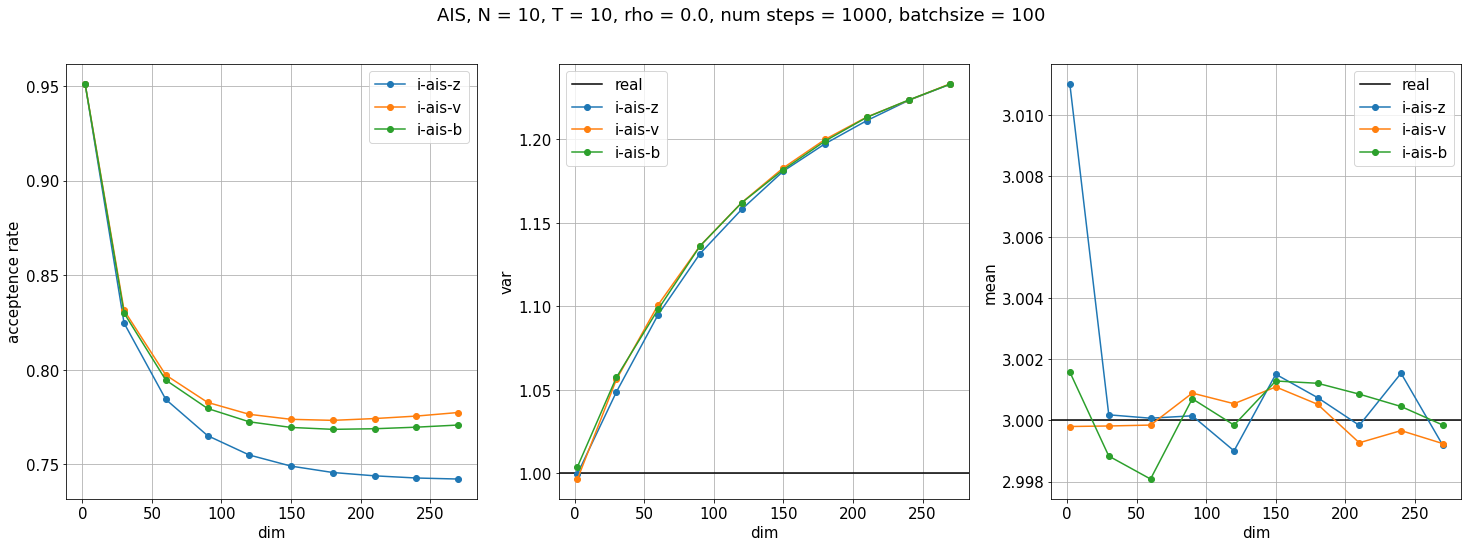

In [97]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'AIS, N = {N}, T = {T}, rho = {rho}, num steps = {n_steps}, batchsize = {batch_size}'
fig.suptitle(name)

axs[0].set_xlabel('dim')
axs[0].set_ylabel('acceptence rate')

axs[1].axhline(1.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('var')

axs[2].axhline(3.0, label='real', color='black')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('mean')

#axs[2].axhline(0.0, label='real', color='black')
#axs[3].set_xlabel('dim')
#axs[3].set_ylabel('ess')

modes_to_plot = ['acceptence', 'mean_var', 'mean_loc']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_independent['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_independent['proposal'][mode], label='proposal init', marker='o')
    #axs[i].plot(dim_arr, results_independent['target'][mode], marker='o')
    # axs[i].plot(dim_arr, results_ais['proposal'][mode], marker='o', label='ais')
    axs[i].plot(dim_arr, results_ais_z['proposal'][mode], marker='o', label='i-ais-z')
    axs[i].plot(dim_arr, results_ais_v['proposal'][mode], marker='o', label='i-ais-v')
    axs[i].plot(dim_arr, results_ais_b['proposal'][mode], marker='o', label='i-ais-b')
    # axs[i].plot(dim_arr, results_cais['proposal'][mode], marker='o', label='cais')

for ax in axs:
    ax.grid()
    ax.legend()

#plt.savefig('../../fig.png')
plt.show()

In [35]:
dim_arr = [2] + [30*(i + 1) for i in range(9)]  

num_points_in_chain = 100
strategy_mean = 'chain' #'chain'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
batch_size = 1
n_steps = 1000 #5000

var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_proposal = 0.0
loc_1_target = 3.0
loc_2_target = -3.0

In [37]:
N = 10

T = 50
betas = np.linspace(1., 0., T)

grad_step = 0.5
eps_scale = (2*grad_step)**0.5

rho = 0.99
method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_v' 
mode_init = 'proposal'
print_results = True

results_ais_v_2 = run_experiments_2_gaussians(dim_arr,
                                              scale_proposal,
                                              scale_target,
                                              loc_1_target,
                                              loc_2_target,
                                              num_points_in_chain,
                                              strategy_mean,
                                              device,
                                              batch_size,
                                              method_params,
                                              random_seed=random_seed,
                                              loc_proposal=loc_proposal,
                                              mode_init=mode_init,
                                              method=method,
                                              print_results=print_results)

  0%|          | 1/1000 [00:00<01:59,  8.33it/s]

------------------
mode = proposal
dim = 2


  0%|          | 1/1000 [00:00<01:59,  8.38it/s]

mean estimation of acceptence rate = 0.853964626789093
mean estimation of target variance = 0.8731001708867012
mean estimation of 1 mode mean  = 2.9024295806884766
mean estimation of 2 mode mean  = -2.854933738708496
mean estimation of JSD  = 0.011557918041944504
mean estimation of HQR  = 1.0
mean estimation of ESS = 0.8181818181818182
------
dim = 30


  0%|          | 1/1000 [00:00<02:00,  8.28it/s]

Unfortunalely, no points were assigned to 1st mode, default estimation - zero
mean estimation of acceptence rate = 0.7475875616073608
mean estimation of target variance = 1.332566669892282e-13
mean estimation of 1 mode mean  = nan
mean estimation of 2 mode mean  = -2.9235005378723145
mean estimation of JSD  = 0.04247488081455231
mean estimation of HQR  = 1.0
mean estimation of ESS = 0.0
------
dim = 60


 12%|█▏        | 123/1000 [00:14<01:44,  8.38it/s]


KeyboardInterrupt: 

In [16]:
N = 10

T = 50
betas = np.linspace(1., 0., T)

grad_step = 0.5
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas}
random_seed = 42
method = 'i_ais_z' 
mode_init = 'proposal'
print_results = True

results_ais_z_2 = run_experiments_2_gaussians(dim_arr,
                                              scale_proposal,
                                              scale_target,
                                              loc_1_target,
                                              loc_2_target,
                                              num_points_in_chain,
                                              strategy_mean,
                                              device,
                                              batch_size,
                                              method_params,
                                              random_seed=random_seed,
                                              loc_proposal=loc_proposal,
                                              mode_init=mode_init,
                                              method=method,
                                              print_results=print_results)

------------------
mode = proposal
dim = 2
mean estimation of acceptence rate = 0.9501599073410034
mean estimation of target variance = 0.8360559734957866
mean estimation of 1 mode mean  = 2.9927031993865967
mean estimation of 2 mode mean  = -2.978496789932251
mean estimation of JSD  = 0.0012547636078667778
mean estimation of HQR  = 0.9489999985694886
mean estimation of ESS = 1.0
------
dim = 30
mean estimation of acceptence rate = 0.8246250152587891
mean estimation of target variance = 1.0094154927167391
mean estimation of 1 mode mean  = 2.9970498085021973
mean estimation of 2 mode mean  = -2.9973626136779785
mean estimation of JSD  = 0.0007290504942648112
mean estimation of HQR  = 0.9347000014781952
mean estimation of ESS = 1.0
------
dim = 60
mean estimation of acceptence rate = 0.7842562794685364
mean estimation of target variance = 1.054222069437614
mean estimation of 1 mode mean  = 3.000354290008545
mean estimation of 2 mode mean  = -3.00114107131958
mean estimation of JSD  = 0.0

In [15]:
N = 10

T = 50
betas = np.linspace(1., 0., T)

grad_step = 0.5
eps_scale = (2*grad_step)**0.5

rho = 0.0
method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_v' 
mode_init = 'proposal'
print_results = True

results_ais_v_2 = run_experiments_2_gaussians(dim_arr,
                                              scale_proposal,
                                              scale_target,
                                              loc_1_target,
                                              loc_2_target,
                                              num_points_in_chain,
                                              strategy_mean,
                                              device,
                                              batch_size,
                                              method_params,
                                              random_seed=random_seed,
                                              loc_proposal=loc_proposal,
                                              mode_init=mode_init,
                                              method=method,
                                              print_results=print_results)

------------------
mode = proposal
dim = 2
mean estimation of acceptence rate = 0.9490920901298523
mean estimation of target variance = 0.8479773402465414
mean estimation of 1 mode mean  = 2.999382972717285
mean estimation of 2 mode mean  = -3.0059633255004883
mean estimation of JSD  = 0.0017562845977954567
mean estimation of HQR  = 0.9503000038862228
mean estimation of ESS = 1.0
------
dim = 30
mean estimation of acceptence rate = 0.8291019797325134
mean estimation of target variance = 1.011074851546863
mean estimation of 1 mode mean  = 2.9995076656341553
mean estimation of 2 mode mean  = -3.0011279582977295
mean estimation of JSD  = 0.002257901676930487
mean estimation of HQR  = 0.9250000047683716
mean estimation of ESS = 1.0
------
dim = 60
mean estimation of acceptence rate = 0.7946879267692566
mean estimation of target variance = 1.0548489045985134
mean estimation of 1 mode mean  = 3.0023205280303955
mean estimation of 2 mode mean  = -2.998466968536377
mean estimation of JSD  = 0.

In [17]:
N = 10

T = 50
betas = np.linspace(1., 0., T)

grad_step = 0.5
eps_scale = (2*grad_step)**0.5

rho = 0.0
method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_b' 
mode_init = 'proposal'
print_results = True

results_ais_b_2 = run_experiments_2_gaussians(dim_arr,
                                              scale_proposal,
                                              scale_target,
                                              loc_1_target,
                                              loc_2_target,
                                              num_points_in_chain,
                                              strategy_mean,
                                              device,
                                              batch_size,
                                              method_params,
                                              random_seed=random_seed,
                                              loc_proposal=loc_proposal,
                                              mode_init=mode_init,
                                              method=method,
                                              print_results=print_results)

------------------
mode = proposal
dim = 2
mean estimation of acceptence rate = 0.9490488171577454
mean estimation of target variance = 0.8516945264056248
mean estimation of 1 mode mean  = 2.9858603477478027
mean estimation of 2 mode mean  = -2.978433132171631
mean estimation of JSD  = 0.0014331762189976872
mean estimation of HQR  = 0.9502000039815903
mean estimation of ESS = 1.0
------
dim = 30
mean estimation of acceptence rate = 0.8291175961494446
mean estimation of target variance = 1.0156596587007918
mean estimation of 1 mode mean  = 3.000274658203125
mean estimation of 2 mode mean  = -3.001983642578125
mean estimation of JSD  = 0.002182794127147645
mean estimation of HQR  = 0.9281000030040741
mean estimation of ESS = 1.0
------
dim = 60
mean estimation of acceptence rate = 0.794581949710846
mean estimation of target variance = 1.0596381950893323
mean estimation of 1 mode mean  = 2.9989256858825684
mean estimation of 2 mode mean  = -3.000972032546997
mean estimation of JSD  = 0.00

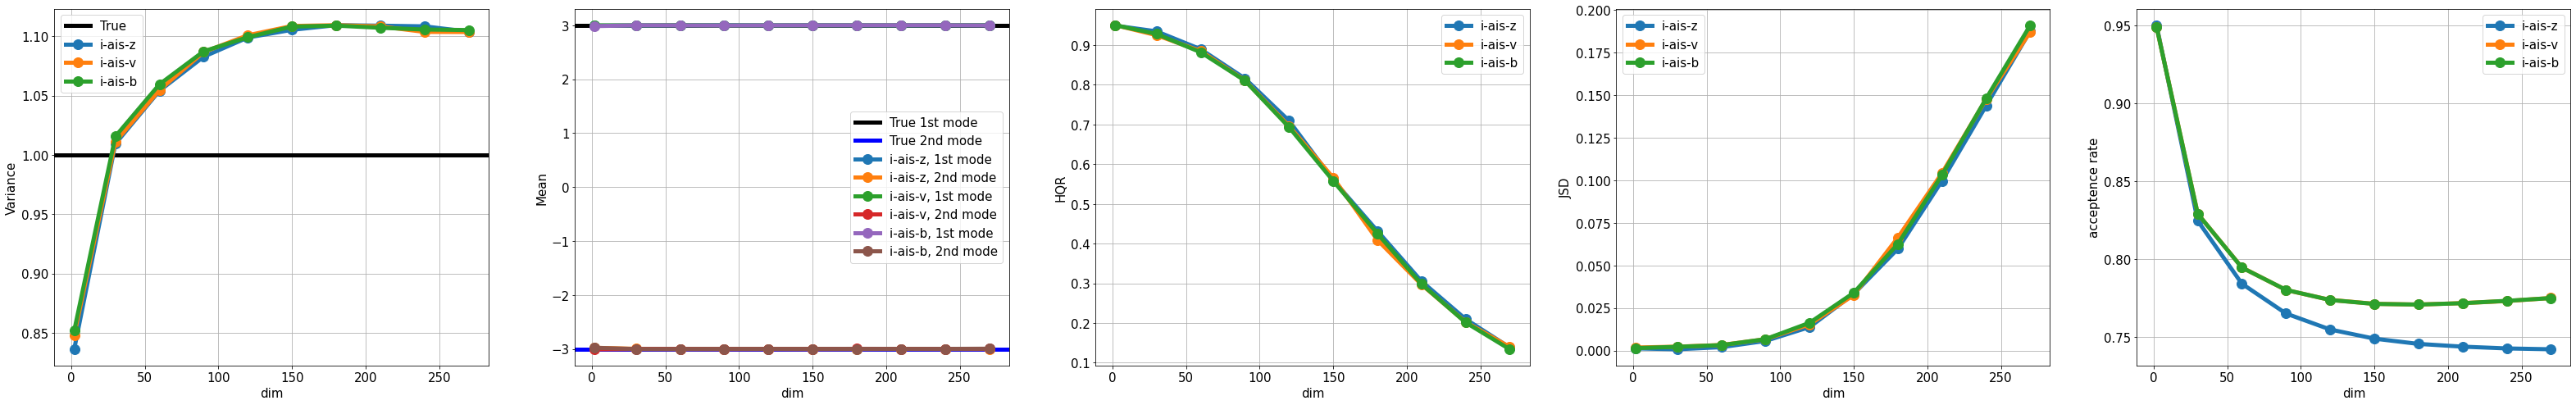

In [24]:
plt.rcParams.update({'font.size': 15})
linewidth = 5
markersize = 12

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(55, 8))
#name = f'SIR, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}, num starts = {batch_size}'
#fig.suptitle(name)

axs[0].axhline(var_target, label='True', color='black', linewidth = linewidth)
axs[0].set_xlabel('dim')
axs[0].set_ylabel('Variance')

axs[1].axhline(loc_1_target, label='True 1st mode', color='black', linewidth = linewidth)
axs[1].axhline(loc_2_target, label='True 2nd mode', color='blue', linewidth = linewidth)
axs[1].set_xlabel('dim')
axs[1].set_ylabel('Mean')

#axs[2].set_xlabel('dim')
#axs[2].set_ylabel('ESS')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('HQR')

axs[3].set_xlabel('dim')
axs[3].set_ylabel('JSD')

axs[4].set_xlabel('dim')
axs[4].set_ylabel('acceptence rate')

modes_to_plot = ['mean_var', 'mean_loc_1', 'mean_loc_2', 'mean_hqr', 'mean_jsd', 'acceptence']
for i, mode in enumerate(modes_to_plot):
    if i == 1:
        axs[i].plot(dim_arr, results_ais_z_2['proposal']['mean_loc_1'], 
                    label='i-ais-z, 1st mode', marker='o', linewidth = linewidth, 
                   markersize = markersize )
        axs[i].plot(dim_arr, results_ais_z_2['proposal']['mean_loc_2'], 
                    label='i-ais-z, 2nd mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        axs[i].plot(dim_arr, results_ais_v_2['proposal']['mean_loc_1'], 
                    label='i-ais-v, 1st mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_2'], 
        #            label='target init, 2nd mode estimation', marker='o')
        axs[i].plot(dim_arr, results_ais_v_2['proposal']['mean_loc_2'], 
                    label='i-ais-v, 2nd mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        axs[i].plot(dim_arr, results_ais_b_2['proposal']['mean_loc_1'], 
                    label='i-ais-b, 1st mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        axs[i].plot(dim_arr, results_ais_b_2['proposal']['mean_loc_2'], 
                    label='i-ais-b, 2nd mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
    elif i == 2:
        pass
    else:
        if i == 0:
            j = 0
        else:
            j = i - 1
        axs[j].plot(dim_arr, results_ais_z_2['proposal'][mode], 
                    label='i-ais-z', marker='o', linewidth = linewidth,
                   markersize  = markersize)
        axs[j].plot(dim_arr, results_ais_v_2['proposal'][mode], 
                    label='i-ais-v', marker='o', linewidth = linewidth,
                   markersize  = markersize)
        axs[j].plot(dim_arr, results_ais_b_2['proposal'][mode], 
                    label='i-ais-b', marker='o', linewidth = linewidth,
                   markersize  = markersize)
    
for ax in axs:
    ax.grid()
    ax.legend()

#plt.savefig('../../fig.png')
plt.show()

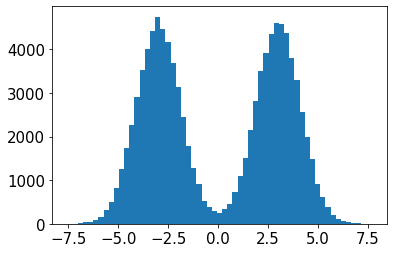

In [22]:
_ = plt.hist(results_ais_b_2[mode_init]['history_first'][-1].reshape(-1), bins='auto')

# 25 Gaussians

In [8]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
sigma = 0.05
n_dim = 2
target_args = DotDict()
target_args.device = device
target_args.num_gauss = 25
n_col = 5
n_row = target_args.num_gauss // n_col
s = 1
###create points

coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = [torch.tensor([(i-2)*s,(j-2)*s] + [0]* (n_dim - 2)).to(device) 
        for i in range(n_col) for j in range(n_row)]
target_args.locs = locs
target_args.covs = [(sigma**2)*torch.eye(n_dim).to(device)]*target_args.num_gauss
target_args.dim = n_dim
true_target = Gaussian_mixture(target_args).log_prob

In [9]:
s = 1
dim = 2
locs = [torch.tensor([(i-2)*s,(j-2)*s] + [0]* (dim - 2)).to(device) 
            for i in range(n_col) for j in range(n_row)]

In [10]:
locs

[tensor([-2, -2], device='cuda:1'),
 tensor([-2, -1], device='cuda:1'),
 tensor([-2,  0], device='cuda:1'),
 tensor([-2,  1], device='cuda:1'),
 tensor([-2,  2], device='cuda:1'),
 tensor([-1, -2], device='cuda:1'),
 tensor([-1, -1], device='cuda:1'),
 tensor([-1,  0], device='cuda:1'),
 tensor([-1,  1], device='cuda:1'),
 tensor([-1,  2], device='cuda:1'),
 tensor([ 0, -2], device='cuda:1'),
 tensor([ 0, -1], device='cuda:1'),
 tensor([0, 0], device='cuda:1'),
 tensor([0, 1], device='cuda:1'),
 tensor([0, 2], device='cuda:1'),
 tensor([ 1, -2], device='cuda:1'),
 tensor([ 1, -1], device='cuda:1'),
 tensor([1, 0], device='cuda:1'),
 tensor([1, 1], device='cuda:1'),
 tensor([1, 2], device='cuda:1'),
 tensor([ 2, -2], device='cuda:1'),
 tensor([ 2, -1], device='cuda:1'),
 tensor([2, 0], device='cuda:1'),
 tensor([2, 1], device='cuda:1'),
 tensor([2, 2], device='cuda:1')]

In [14]:
def run_experiment_gaussians_2d(scale_proposal, 
                                scale_target, 
                                num_points_in_chain, 
                                strategy_mean,
                                device,
                                batch_size,
                                method_params,
                                random_seed=42,
                                loc_proposal=0.0,
                                mode_init='proposal',
                                method='sir_independent',
                                print_results=True):
    dict_results = {mode_init: {'mean_loc': [], 
                                'mean_var': [], 
                                'mean_jsd': [],
                                'mean_hqr': [],
                                'ess': [], 
                                'history_first': [], 
                                'history_norm': []}}
   
    if print_results:
        print("------------------")
        print(f"method = {method}")
        print(f"mode = {mode_init}")
   
    dim = 2
    num_gauss = 25
    
    if print_results:
        print(f"dim = {dim}")

    target_args = DotDict()
    target_args.device = device
    target_args.num_gauss = num_gauss
    n_col = 5
    n_row = target_args.num_gauss // n_col
    s = 1
    ###create points
    coef_gaussian = 1./target_args.num_gauss
    target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
    locs = [torch.tensor([(i-2)*s,(j-2)*s] + [0]* (dim - 2)).to(device) 
            for i in range(n_col) for j in range(n_row)]
    target_args.locs = locs
    target_args.covs = [(scale_target**2)*torch.eye(dim).to(device)]*target_args.num_gauss
    target_args.dim = dim
    target = Gaussian_mixture(target_args)
    
    
    proposal = init_independent_normal(scale_proposal, dim, device, loc_proposal)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    if (mode_init == 'target') and (method != 'ais'):
        start = target.sample([batch_size])
    elif mode_init == 'proposal' and (method != 'ais'):
        start = proposal.sample([batch_size])
    elif (mode_init == 'target') and (method == 'ais'):
        start = target.sample([batch_size, len(method_params['betas'])])
    elif mode_init == 'proposal' and (method == 'ais'):
        start = proposal.sample([batch_size, len(method_params['betas'])])
    else:
        raise ValueError('Unknown initialization method')
    if method == 'sir_correlated':
        alpha = (1 - method_params['c']/dim)**0.5
        history = sir_correlated_dynamics(start, 
                                          target,
                                          proposal, 
                                          method_params['n_steps'], 
                                          method_params['N'],
                                          alpha)
        acceptence = 1.0
    elif method == 'sir_independent':
        history = sir_independent_dynamics(start, 
                                           target,
                                           proposal, 
                                           method_params['n_steps'], 
                                           method_params['N'])
        acceptence = 1.0
    elif method == 'ais':
        history, acceptence = ais_dynamics(start, 
                                           target.log_prob,
                                           proposal, 
                                           method_params['n_steps'], 
                                           method_params['grad_step'], 
                                           method_params['eps_scale'],
                                           method_params['N'], 
                                           method_params['betas'], 
                                           method_params['rhos'])

    elif method == 'i_ais_z':
        history, acceptence = i_ais_z_dynamics(start, 
                                               target.log_prob,
                                               method_params['n_steps'], 
                                               method_params['grad_step'], 
                                               method_params['eps_scale'],
                                               method_params['N'], 
                                               method_params['betas'])

    elif method == 'i_ais_v':
        history, acceptence = i_ais_v_dynamics(start, 
                                               target.log_prob,
                                               method_params['n_steps'], 
                                               method_params['grad_step'], 
                                               method_params['eps_scale'],
                                               method_params['N'], 
                                               method_params['betas'],
                                               method_params['rho'])

    elif method == 'i_ais_b':
        history, acceptence = i_ais_b_dynamics(start, 
                                               target.log_prob,
                                               method_params['n_steps'], 
                                               method_params['grad_step'], 
                                               method_params['eps_scale'],
                                               method_params['N'], 
                                               method_params['betas'],
                                               method_params['rho'])

    else:
        raise ValueError('Unknown sampling method')
    
    torch_locs = torch.stack(locs, 0).cpu()
    np_locs = torch_locs.numpy()
    evolution = Evolution(None, locs=torch_locs, 
                          sigma=scale_target)
    
    last_history = history[max(1, len(history)-num_points_in_chain - 1):]#-1]
    all_history_np = torch.stack(history, axis = 0).cpu().numpy()
    torch_last_history = torch.stack(last_history, axis = 0).cpu()

    result_np = torch.stack(last_history, axis = 0).cpu().numpy()
    
    modes_var_arr = []
    h_q_r_arr = []
    jsd_arr = []
    means_est = torch.zeros(num_gauss, dim)
    
    num_found_mode = np.zeros(num_gauss)
    means_est_np = np.zeros((num_gauss, dim))
         
    if strategy_mean == 'starts':
         #print(torch_last_history.shape)
        for i in range(num_points_in_chain):
            X_gen = torch_last_history[i, :, :]
            #print(X_gen.shape, evolution.locs.shape)
            assignment = Evolution.make_assignment(X_gen, evolution.locs, evolution.sigma)
            mode_var = Evolution.compute_mode_std(X_gen, assignment).item()**2
            #print(X_gen.shape, mode_var)
            modes_mean, found_modes_ind = Evolution.compute_mode_mean(X_gen, assignment)
            for j in range(num_gauss):
                if j in found_modes_ind:
                    num_found_mode[j] += 1
                    means_est[j, :] += modes_mean[j]

            h_q_r = Evolution.compute_high_quality_rate(assignment).item()
            jsd = Evolution.compute_jsd(assignment).item()

            modes_var_arr.append(mode_var)
            h_q_r_arr.append(h_q_r)
            jsd_arr.append(jsd)

    elif strategy_mean == 'chain':            
        #print(evolution.locs)
        for i in range(batch_size):
            X_gen = torch_last_history[:, i, :]
            assignment = Evolution.make_assignment(X_gen, evolution.locs, evolution.sigma)
            mode_var = Evolution.compute_mode_std(X_gen, assignment).item()**2

            modes_mean, found_modes_ind = Evolution.compute_mode_mean(X_gen, assignment)
            #print(f"found_modes_ind = {found_modes_ind}")
            for j in range(num_gauss):
                if j in found_modes_ind:
                    num_found_mode[j] += 1
                    means_est[j, :] += modes_mean[j]
            #print(f"batch = {i}, modes_mean = {modes_mean}")
            h_q_r = Evolution.compute_high_quality_rate(assignment).item()
            jsd = Evolution.compute_jsd(assignment).item()

            modes_var_arr.append(mode_var)

            h_q_r_arr.append(h_q_r)
            jsd_arr.append(jsd)     

    else:
        raise ValueError('Unknown method of mean') 
         
    jsd_result = np.array(jsd_arr).mean()
    modes_var_result = np.array(modes_var_arr).mean()
    h_q_r_result = np.array(h_q_r_arr).mean()
    for j in range(num_gauss):
        if num_found_mode[j] == 0:
            print(f"Unfortunalely, no points were assigned to {j}-th mode, default estimation - zero")
        else:
            means_est_np[j, :] = (means_est[j, :]/num_found_mode[j]).detach().cpu().numpy()
            print(f"Estimation of {j}-th mean: {means_est_np[j, :]}, true = {np_locs[j, :]}")


    result_np_1 = result_np[:-1]
    result_np_2 = result_np[1:]
    diff = (result_np_1 == result_np_2).sum(axis = 2)
    ess_bs = (diff != dim).mean(axis = 0)
    ess = ess_bs.mean()
    first_coord_history = all_history_np[:, :, 0]
    norm_history = np.linalg.norm(all_history_np, axis = -1)

    if print_results:
        print(f"mean estimation of acceptence rate = {acceptence}")
        print(f"mean estimation of target variance = {modes_var_result}, true = {scale_target ** 2}")
        print(f"mean estimation of JSD  = {jsd_result}")
        print(f"mean estimation of HQR  = {h_q_r_result}")
        print(f"mean estimation of ESS = {ess}")
        print("------")
    
    dict_results[mode_init]['mean_var'].append(modes_var_result)
    dict_results[mode_init]['mean_jsd'].append(jsd_result)
    dict_results[mode_init]['mean_hqr'].append(h_q_r_result)
    dict_results[mode_init]['ess'].append(ess)
    dict_results[mode_init]['history_first'].append(first_coord_history)
    dict_results[mode_init]['history_norm'].append(norm_history)
                                                   
    return dict_results

In [26]:
num_points_in_chain = 100
strategy_mean = 'chain' #'chain'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
batch_size = 1
n_steps = 500 #5000

var_proposal = 2.0
var_target = 0.05**2
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_proposal = 0.0

In [27]:
N = 10

T = 100
betas = np.linspace(1., 0., T)

grad_step = 1
eps_scale = (2*grad_step)**0.5

rho = 0.0
method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_v' 
mode_init = 'proposal'
print_results = True

results_ais_v_2d = run_experiment_gaussians_2d(scale_proposal, 
                                               scale_target, 
                                               num_points_in_chain, 
                                               strategy_mean,
                                               device,
                                               batch_size,
                                               method_params,
                                               random_seed=random_seed,
                                               loc_proposal=loc_proposal,
                                               mode_init=mode_init,
                                               method=method,
                                               print_results=print_results)

  0%|          | 0/500 [00:00<?, ?it/s]

------------------
method = i_ais_v
mode = proposal
dim = 2


100%|██████████| 500/500 [09:04<00:00,  1.09s/it]

Unfortunalely, no points were assigned to 0-th mode, default estimation - zero
Estimation of 1-th mean: [-2.03693485 -0.98252189], true = [-2 -1]
Unfortunalely, no points were assigned to 2-th mode, default estimation - zero
Estimation of 3-th mean: [-2.01602125  1.03533113], true = [-2  1]
Unfortunalely, no points were assigned to 4-th mode, default estimation - zero
Estimation of 5-th mean: [-1.01051342 -1.97178519], true = [-1 -2]
Estimation of 6-th mean: [-0.97347701 -0.99545258], true = [-1 -1]
Unfortunalely, no points were assigned to 7-th mode, default estimation - zero
Unfortunalely, no points were assigned to 8-th mode, default estimation - zero
Unfortunalely, no points were assigned to 9-th mode, default estimation - zero
Estimation of 10-th mean: [-0.02287071 -1.95821822], true = [ 0 -2]
Unfortunalely, no points were assigned to 11-th mode, default estimation - zero
Estimation of 12-th mean: [0.01894966 0.02917732], true = [0 0]
Estimation of 13-th mean: [-0.00419758  0.9532

In [28]:
num_points_in_chain = 200
strategy_mean = 'chain' #'chain'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
batch_size = 1
n_steps = 1000 #5000

var_proposal = 2.0
var_target = 0.05**2
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_proposal = 0.0

In [30]:
N = 10

T = 10
betas = np.linspace(1., 0., T)

grad_step = 1e-1
eps_scale = (2*grad_step)**0.5

rho = 0.0
method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_v' 
mode_init = 'proposal'
print_results = True

results_ais_v_2d = run_experiment_gaussians_2d(scale_proposal, 
                                               scale_target, 
                                               num_points_in_chain, 
                                               strategy_mean,
                                               device,
                                               batch_size,
                                               method_params,
                                               random_seed=random_seed,
                                               loc_proposal=loc_proposal,
                                               mode_init=mode_init,
                                               method=method,
                                               print_results=print_results)

  0%|          | 0/1000 [00:00<?, ?it/s]

------------------
method = i_ais_v
mode = proposal
dim = 2


100%|██████████| 1000/1000 [01:38<00:00, 10.20it/s]


Unfortunalely, no points were assigned to 0-th mode, default estimation - zero
Unfortunalely, no points were assigned to 1-th mode, default estimation - zero
Unfortunalely, no points were assigned to 2-th mode, default estimation - zero
Unfortunalely, no points were assigned to 3-th mode, default estimation - zero
Estimation of 4-th mean: [-1.95809305  2.07971501], true = [-2  2]
Estimation of 5-th mean: [-1.03718436 -1.9471457 ], true = [-1 -2]
Unfortunalely, no points were assigned to 6-th mode, default estimation - zero
Estimation of 7-th mean: [-0.9545297   0.02060284], true = [-1  0]
Estimation of 8-th mean: [-1.01277065  0.97168458], true = [-1  1]
Unfortunalely, no points were assigned to 9-th mode, default estimation - zero
Estimation of 10-th mean: [-0.02366468 -2.03236485], true = [ 0 -2]
Estimation of 11-th mean: [ 0.01930613 -0.94799405], true = [ 0 -1]
Estimation of 12-th mean: [-0.00641576 -0.02590558], true = [0 0]
Estimation of 13-th mean: [-0.02741851  1.00358725], tru

In [87]:
N = 10

T = 100
betas = np.linspace(1., 0., T)

grad_step = 0.5
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas}
random_seed = 42
method = 'i_ais_z' 
mode_init = 'proposal'
print_results = True

results_ais_z_2d = run_experiment_gaussians_2d(dim_arr,
                                               scale_proposal,
                                               scale_target,
                                               num_points_in_chain,
                                               strategy_mean,
                                               device,
                                               batch_size,
                                               method_params,
                                               random_seed=random_seed,
                                               loc_proposal=loc_proposal,
                                               mode_init=mode_init,
                                               method=method,
                                               print_results=print_results)

  0%|          | 0/1000 [00:00<?, ?it/s]

------------------
method = i_ais_z
mode = proposal
dim = 2


100%|██████████| 1000/1000 [18:52<00:00,  1.13s/it]


Estimation of 0-th mean: [-2.00293422 -2.00025392], true = [-2 -2]
Estimation of 1-th mean: [-1.99506342 -0.99556994], true = [-2 -1]
Estimation of 2-th mean: [-2.00196338  0.00305883], true = [-2  0]
Estimation of 3-th mean: [-1.99691606  0.99638206], true = [-2  1]
Estimation of 4-th mean: [-1.99745572  1.99320364], true = [-2  2]
Estimation of 5-th mean: [-0.99888748 -2.0033145 ], true = [-1 -2]
Estimation of 6-th mean: [-0.98795348 -1.01196873], true = [-1 -1]
Estimation of 7-th mean: [-0.9945901  -0.00241863], true = [-1  0]
Estimation of 8-th mean: [-1.00798643  0.99112642], true = [-1  1]
Estimation of 9-th mean: [-1.00189173  2.00154114], true = [-1  2]
Estimation of 10-th mean: [ 1.02267053e-03 -1.99502897e+00], true = [ 0 -2]
Estimation of 11-th mean: [-0.00186805 -1.00300634], true = [ 0 -1]
Estimation of 12-th mean: [-0.00370869  0.00550522], true = [0 0]
Estimation of 13-th mean: [-3.56091216e-04  1.00244474e+00], true = [0 1]
Estimation of 14-th mean: [0.00879237 1.992504

In [86]:
N = 10

T = 10
betas = np.linspace(1., 0., T)

grad_step = 1e-2
eps_scale = (2*grad_step)**0.5
rho = 0.0

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_v' 
mode_init = 'proposal'
print_results = True

results_ais_v_2d = run_experiment_gaussians_2d(dim_arr,
                                               scale_proposal,
                                               scale_target,
                                               num_points_in_chain,
                                               strategy_mean,
                                               device,
                                               batch_size,
                                               method_params,
                                               random_seed=random_seed,
                                               loc_proposal=loc_proposal,
                                               mode_init=mode_init,
                                               method=method,
                                               print_results=print_results)

  0%|          | 0/1000 [00:00<?, ?it/s]

------------------
method = i_ais_v
mode = proposal
dim = 2


100%|██████████| 1000/1000 [19:01<00:00,  1.14s/it]


Estimation of 0-th mean: [-2.00179124 -2.01106501], true = [-2 -2]
Estimation of 1-th mean: [-2.00560164 -0.99415922], true = [-2 -1]
Estimation of 2-th mean: [-2.01341629e+00 -1.91583810e-03], true = [-2  0]
Estimation of 3-th mean: [-2.00832534  1.01865494], true = [-2  1]
Estimation of 4-th mean: [-2.02325916  2.00190091], true = [-2  2]
Estimation of 5-th mean: [-1.00672817 -2.01266193], true = [-1 -2]
Estimation of 6-th mean: [-0.99762505 -1.00089598], true = [-1 -1]
Estimation of 7-th mean: [-1.00360036 -0.00129205], true = [-1  0]
Estimation of 8-th mean: [-0.99943763  1.00690925], true = [-1  1]
Estimation of 9-th mean: [-1.00392008  2.00517774], true = [-1  2]
Estimation of 10-th mean: [-0.00645061 -2.00712085], true = [ 0 -2]
Estimation of 11-th mean: [-0.00405349 -0.99865454], true = [ 0 -1]
Estimation of 12-th mean: [0.00032508 0.00888845], true = [0 0]
Estimation of 13-th mean: [0.00298738 0.99822253], true = [0 1]
Estimation of 14-th mean: [0.00349313 2.00386858], true = 

In [93]:
N = 10

T = 10
betas = np.linspace(1., 0., T)

grad_step = 1e-2
eps_scale = (2*grad_step)**0.5
rho = 0.0

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_v' 
mode_init = 'proposal'
print_results = True

results_ais_v_2d = run_experiment_gaussians_2d(dim_arr,
                                               scale_proposal,
                                               scale_target,
                                               num_points_in_chain,
                                               strategy_mean,
                                               device,
                                               batch_size,
                                               method_params,
                                               random_seed=random_seed,
                                               loc_proposal=loc_proposal,
                                               mode_init=mode_init,
                                               method=method,
                                               print_results=print_results)

  0%|          | 1/1000 [00:00<01:41,  9.88it/s]

------------------
method = i_ais_v
mode = proposal
dim = 2


100%|██████████| 1000/1000 [01:45<00:00,  9.45it/s]


Estimation of 0-th mean: [-2.03706908 -1.99625778], true = [-2 -2]
Estimation of 1-th mean: [-2.00475645 -1.00413692], true = [-2 -1]
Estimation of 2-th mean: [-1.99362409e+00  1.13910064e-03], true = [-2  0]
Estimation of 3-th mean: [-2.00020504  1.00246871], true = [-2  1]
Estimation of 4-th mean: [-2.00168967  2.01232076], true = [-2  2]
Estimation of 5-th mean: [-0.99570405 -1.99823606], true = [-1 -2]
Estimation of 6-th mean: [-0.99881506 -1.00126779], true = [-1 -1]
Estimation of 7-th mean: [-0.99574637  0.0015602 ], true = [-1  0]
Estimation of 8-th mean: [-0.99789041  0.99950945], true = [-1  1]
Estimation of 9-th mean: [-0.99877942  1.99767399], true = [-1  2]
Estimation of 10-th mean: [ 0.00246934 -2.00305748], true = [ 0 -2]
Estimation of 11-th mean: [ 9.10243398e-05 -9.99466121e-01], true = [ 0 -1]
Estimation of 12-th mean: [1.54343681e-04 3.04769719e-06], true = [0 0]
Estimation of 13-th mean: [0.00145452 0.99878031], true = [0 1]
Estimation of 14-th mean: [-1.14626717e-03

In [94]:
N = 10

T = 10
betas = np.linspace(1., 0., T)

grad_step = 1e-2
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas}
random_seed = 42
method = 'i_ais_z' 
mode_init = 'proposal'
print_results = True

results_ais_v_2d = run_experiment_gaussians_2d(dim_arr,
                                               scale_proposal,
                                               scale_target,
                                               num_points_in_chain,
                                               strategy_mean,
                                               device,
                                               batch_size,
                                               method_params,
                                               random_seed=random_seed,
                                               loc_proposal=loc_proposal,
                                               mode_init=mode_init,
                                               method=method,
                                               print_results=print_results)

  0%|          | 0/1000 [00:00<?, ?it/s]

------------------
method = i_ais_z
mode = proposal
dim = 2


100%|██████████| 1000/1000 [01:34<00:00, 10.56it/s]


Estimation of 0-th mean: [-1.99823844 -1.99793339], true = [-2 -2]
Unfortunalely, no points were assigned to 1-th mode, default estimation - zero
Estimation of 2-th mean: [-1.99876070e+00  1.49103673e-03], true = [-2  0]
Estimation of 3-th mean: [-1.99777174  0.99428433], true = [-2  1]
Unfortunalely, no points were assigned to 4-th mode, default estimation - zero
Estimation of 5-th mean: [-0.99973714 -2.0009408 ], true = [-1 -2]
Estimation of 6-th mean: [-1.00168872 -1.00328588], true = [-1 -1]
Estimation of 7-th mean: [-9.98188317e-01 -1.90752180e-05], true = [-1  0]
Estimation of 8-th mean: [-0.99910682  0.99571794], true = [-1  1]
Estimation of 9-th mean: [-0.99882317  1.99731565], true = [-1  2]
Estimation of 10-th mean: [-7.45488564e-04 -1.99775982e+00], true = [ 0 -2]
Estimation of 11-th mean: [ 6.94427654e-05 -1.00141871e+00], true = [ 0 -1]
Estimation of 12-th mean: [0.0045744  0.00349436], true = [0 0]
Estimation of 13-th mean: [-0.00496526  1.00019932], true = [0 1]
Estimati

In [95]:
N = 10

T = 10
betas = np.linspace(1., 0., T)

grad_step = 1e-2
eps_scale = (2*grad_step)**0.5

rho = 0.0
method_params = {'n_steps': n_steps, 
                'N': N, 
                'grad_step': grad_step, 
                'eps_scale': eps_scale, 
                'betas': betas,
                'rho': rho}
random_seed = 42
method = 'i_ais_b' 
mode_init = 'proposal'
print_results = True

results_ais_b_2d = run_experiment_gaussians_2d(dim_arr,
                                               scale_proposal,
                                               scale_target,
                                               num_points_in_chain,
                                               strategy_mean,
                                               device,
                                               batch_size,
                                               method_params,
                                               random_seed=random_seed,
                                               loc_proposal=loc_proposal,
                                               mode_init=mode_init,
                                               method=method,
                                               print_results=print_results)

  0%|          | 0/1000 [00:00<?, ?it/s]

------------------
method = i_ais_b
mode = proposal
dim = 2


100%|██████████| 1000/1000 [03:26<00:00,  4.83it/s]


Estimation of 0-th mean: [-1.97090423 -1.97284985], true = [-2 -2]
Estimation of 1-th mean: [-1.99604833 -1.0032078 ], true = [-2 -1]
Estimation of 2-th mean: [-1.99988639  0.00222055], true = [-2  0]
Estimation of 3-th mean: [-2.00088477  0.99972248], true = [-2  1]
Estimation of 4-th mean: [-2.0056057   2.00974655], true = [-2  2]
Estimation of 5-th mean: [-0.99877191 -2.00597239], true = [-1 -2]
Estimation of 6-th mean: [-1.00152373 -1.00294769], true = [-1 -1]
Estimation of 7-th mean: [-1.00424516  0.00120636], true = [-1  0]
Estimation of 8-th mean: [-1.00567031  1.00105274], true = [-1  1]
Estimation of 9-th mean: [-0.99901998  1.98798633], true = [-1  2]
Estimation of 10-th mean: [-3.87273103e-05 -2.00541139e+00], true = [ 0 -2]
Estimation of 11-th mean: [ 0.00269514 -0.99885768], true = [ 0 -1]
Estimation of 12-th mean: [0.00058566 0.00105103], true = [0 0]
Estimation of 13-th mean: [0.00125978 0.99933326], true = [0 1]
Estimation of 14-th mean: [0.00758093 2.00941062], true = 

# Non-symmetric gaussians

In [34]:
loc_target = 4.0
loc_proposal = 0.0

var_proposal = 2.0
scale_proposal = var_proposal ** 0.5
num_points_in_chain = 5
strategy_mean = 'chain'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
batch_size = 50
n_steps = 50

In [35]:
dim = 10
scales_target = torch.linspace(0.1, 1.0, steps = dim)
locs_target = loc_target*torch.ones(dim)
target = init_independent_normal_scale(scales_target,
                                       locs_target,
                                       device)
proposal = init_independent_normal(scale_proposal, dim, 
                                    device, loc_proposal)

In [36]:
target.loc.device

device(type='cuda', index=1)

In [48]:
rs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 1.0]
N = 10
T = 100
grad_step = 0.1
eps_scale = (2*grad_step)**0.5
betas = list(np.linspace(1., 0., T)**.5)

vals = []
var = []
mean = []

print(f"target var = {scales_target**2}")

for r in rs:
    rhos = np.linspace(r, r, T) #[0.9]*T #np.linspace(1, .7, T)

    method_params = {'n_steps': n_steps, 
                    'N': N, 
                    'grad_step': grad_step, 
                    'eps_scale': eps_scale, 
                    'betas': betas,
                    'rho': 1.0,
                    'rhos': rhos}

    start = proposal.sample([batch_size, len(betas)])

    history, acceptence, traj_hist = citerais_ula_dynamics(start, 
                                                target.log_prob,
                                                proposal,
                                                method_params['n_steps'], 
                                                method_params['grad_step'], 
                                                method_params['eps_scale'],
                                                method_params['N'], 
                                                method_params['betas'],
                                                method_params['rhos'], max_n_rej=1000, pbern=1.0)
    
    last_history = history[-num_points_in_chain:]
    result = torch.stack(last_history, 0)
    ess = (result[1:] != result[:-1]).float().min(-1)[0].mean().item()
    print(f"rho = {r}, ess = {ess}")
    vals.append(ess)

    result_np = result.cpu().numpy()
    result_var = np.var(result_np, axis = 0, ddof=1).mean(axis = 0)
    result_mean = np.mean(result_np, axis = 0).mean(axis = 0)
    var.append(result_var)
    mean.append(result_mean)
    
    print(f"rho = {r}, var estimation = {result_var}")
    print(f"rho = {r}, mean estimation = {result_mean}")

  0%|          | 0/50 [00:00<?, ?it/s]

target var = tensor([0.0100, 0.0400, 0.0900, 0.1600, 0.2500, 0.3600, 0.4900, 0.6400, 0.8100,
        1.0000])


  0%|          | 0/50 [00:00<?, ?it/s]

rho = 0.0, ess = 0.9300000071525574
rho = 0.0, var estimation = [          nan 3.2450952e+07 2.1146230e-01 2.5739127e-01 2.8632215e-01
 4.2481187e-01 4.7251529e-01 6.7683244e-01 8.8425899e-01 1.1113511e+00]
rho = 0.0, mean estimation = [        nan 232.27632     3.9721704   4.023056    4.071855    3.94338
   3.9343636   3.9585667   3.9534388   3.9412549]


  0%|          | 0/50 [00:00<?, ?it/s]

rho = 0.1, ess = 0.9199999570846558
rho = 0.1, var estimation = [          nan 4.0873812e+07 1.7410286e-01 2.3020348e-01 2.7896309e-01
 4.2197061e-01 4.8563525e-01 7.4422830e-01 8.4314364e-01 9.9276918e-01]
rho = 0.1, mean estimation = [        nan -74.44596     4.0168247   4.032115    3.9666781   4.1031013
   3.9679132   3.9886835   4.0191426   4.0051126]


  0%|          | 0/50 [00:00<?, ?it/s]

rho = 0.2, ess = 0.9249999523162842
rho = 0.2, var estimation = [          nan 3.4459504e+07 1.7693871e-01 2.1457520e-01 3.5118043e-01
 3.8435936e-01 5.1637357e-01 7.8304529e-01 9.1383553e-01 1.0268892e+00]
rho = 0.2, mean estimation = [         nan -210.94652      4.025069     4.0314054    4.016586
    3.974527     3.9772367    3.9980905    3.9013178    3.9860048]


  0%|          | 0/50 [00:00<?, ?it/s]

rho = 0.3, ess = 0.9149999618530273
rho = 0.3, var estimation = [          nan 3.4459268e+07 1.6584115e-01 2.3858766e-01 2.8205547e-01
 3.8716212e-01 5.5537719e-01 5.7448667e-01 8.1477022e-01 8.4188408e-01]
rho = 0.3, mean estimation = [        nan 391.55737     3.9569895   3.930005    4.0640254   4.000512
   4.055542    4.019885    4.0221424   4.0046515]


  0%|          | 0/50 [00:00<?, ?it/s]

rho = 0.4, ess = 0.875
rho = 0.4, var estimation = [          nan 3.4865240e+07 1.7104876e-01 1.8447660e-01 2.6153377e-01
 4.0512741e-01 4.5930558e-01 5.8966565e-01 5.0436366e-01 9.7002989e-01]
rho = 0.4, mean estimation = [        nan 166.97957     4.0297823   3.9811509   3.9607437   3.9458954
   4.118518    4.159332    4.0193844   3.994022 ]


  2%|▏         | 1/50 [00:00<00:07,  6.40it/s]

rho = 0.5, ess = 0.9099999666213989
rho = 0.5, var estimation = [          nan 3.2862804e+07 1.6552374e-01 1.8968609e-01 2.4360713e-01
 3.5796380e-01 5.0674921e-01 5.1232922e-01 6.6928869e-01 7.4665809e-01]
rho = 0.5, mean estimation = [         nan -464.05075      3.987792     4.005808     4.02504
    3.9141843    4.0015917    3.957249     4.0652514    4.0344534]


  0%|          | 0/50 [00:00<?, ?it/s]

rho = 0.6, ess = 0.8849999904632568
rho = 0.6, var estimation = [          nan 2.7098954e+07 1.7276616e-01 1.6165364e-01 2.3766713e-01
 3.5168862e-01 4.8798195e-01 4.8371112e-01 6.0121065e-01 7.0590025e-01]
rho = 0.6, mean estimation = [        nan 264.0629      3.9620252   3.9828315   3.9631283   3.976491
   4.0108337   3.94722     4.091701    4.0124264]


  0%|          | 0/50 [00:00<?, ?it/s]

rho = 0.7, ess = 0.9099999666213989
rho = 0.7, var estimation = [          nan 2.6172160e+07 1.2440566e-01 1.5587147e-01 2.1775587e-01
 2.8016394e-01 3.2965454e-01 4.5391765e-01 5.8730567e-01 7.7798444e-01]
rho = 0.7, mean estimation = [        nan 122.856575    3.9739685   3.9625037   4.0038476   3.9711509
   4.0575576   3.97633     4.1423736   4.062395 ]


  0%|          | 0/50 [00:00<?, ?it/s]

rho = 0.8, ess = 0.9099999666213989
rho = 0.8, var estimation = [          nan 1.7522800e+07 1.0588970e-01 1.1780860e-01 1.1861144e-01
 1.9638689e-01 3.1146136e-01 3.9588618e-01 5.1190478e-01 5.2650982e-01]
rho = 0.8, mean estimation = [        nan 230.04381     3.9931986   4.024422    4.0014133   3.996655
   4.1716228   3.9523892   4.0353208   4.078148 ]


  0%|          | 0/50 [00:00<?, ?it/s]

rho = 0.9, ess = 0.9149999618530273
rho = 0.9, var estimation = [          nan 1.2693434e+07 5.4753102e-02 7.9010785e-02 8.6945429e-02
 1.7402218e-01 1.7637974e-01 1.8790241e-01 2.1470365e-01 2.7366063e-01]
rho = 0.9, mean estimation = [        nan 172.63644     3.9439955   3.977367    4.0955634   3.9695158
   3.8822029   4.1732574   3.9383557   3.9169235]


  0%|          | 0/50 [00:00<?, ?it/s]

rho = 0.95, ess = 0.9049999713897705
rho = 0.95, var estimation = [          nan 5.8691960e+06 3.1854060e-02 3.9017301e-02 5.3157482e-02
 6.1613478e-02 8.0086380e-02 1.1897362e-01 1.2969705e-01 1.7675127e-01]
rho = 0.95, mean estimation = [          nan -1510.7015        4.0351534     4.0282707     4.00461
     4.039751      4.004751      4.079888      3.99595       4.032945 ]


  0%|          | 0/50 [00:00<?, ?it/s]

rho = 0.98, ess = 0.9149999618530273
rho = 0.98, var estimation = [          nan 2.5339710e+06 1.5625006e-02 1.5714670e-02 2.1042531e-02
 3.4739383e-02 3.3494558e-02 5.1156968e-02 5.5775877e-02 7.0428759e-02]
rho = 0.98, mean estimation = [       nan 47.810535   4.0324306  4.094604   4.0340137  4.1861644
  3.9467545  4.07515    3.7989132  3.9962018]


100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


rho = 1.0, ess = 0.0
rho = 1.0, var estimation = [          nan 9.1914831e-07 2.2737368e-14 1.5063505e-14 2.2453151e-14
 3.0127010e-14 2.1032065e-14 3.5527137e-14 5.8903993e-14 4.1282533e-14]
rho = 1.0, mean estimation = [        nan 727.39874     3.962046    4.062473    3.8057666   4.024075
   4.112417    3.8543441   4.1926017   3.8643787]


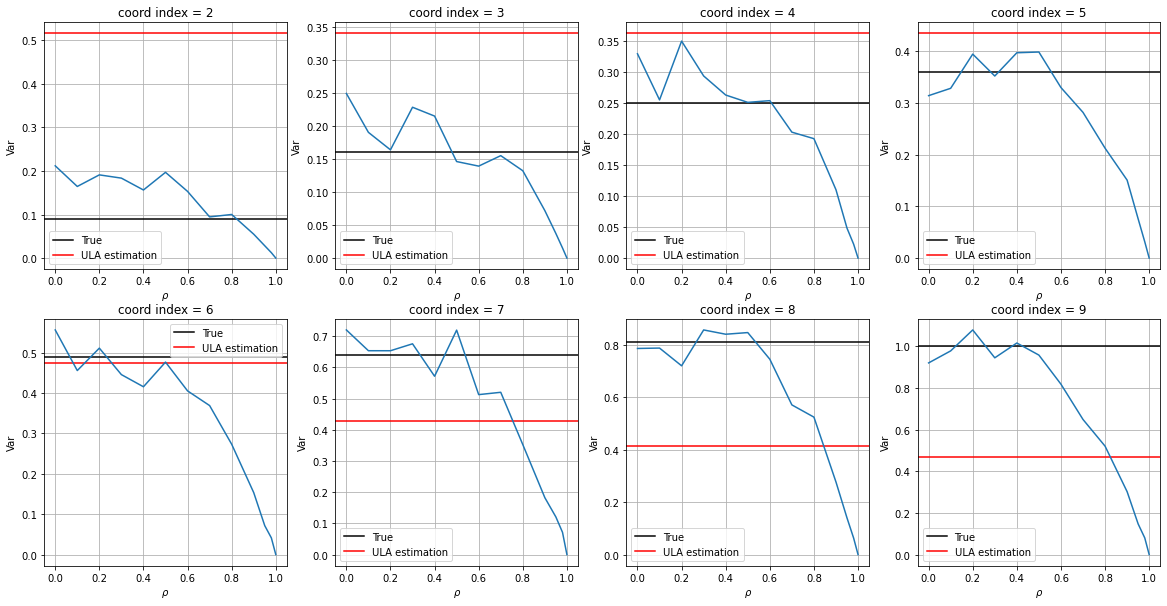

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
true_vars = (scales_target**2).cpu().numpy()
for i in range(8):
    row = i // 4
    col = i % 4
    ind = i + 2
    
    var_est = [var[j][ind] for j in range(len(var))]
    
    axs[row][col].axhline(true_vars[ind], label='True', color='black')
    axs[row][col].axhline(result_var_ula[ind], label='ULA estimation', color='red')
    axs[row][col].plot(rs, var_est)
    axs[row][col].set_ylabel(r'Var')
    axs[row][col].set_xlabel(r'$\rho$')
    axs[row][col].grid()
    axs[row][col].set_title(f"coord index = {ind}")
    axs[row][col].legend()


In [41]:
start = proposal.sample([batch_size])
history = langevin_dynamics(start, target.log_prob, proposal, n_steps, grad_step, eps_scale)

In [43]:
last_history_ula = history[-num_points_in_chain:]
result_ula = torch.stack(last_history_ula, 0)

result_np_ula = result_ula.detach().cpu().numpy()
result_var_ula = np.var(result_np_ula, axis = 0, ddof=1).mean(axis = 0)

In [45]:
result_var_ula

array([          nan, 3.0129802e+18, 5.1584023e-01, 3.4001857e-01,
       3.6170784e-01, 4.3446979e-01, 4.7530293e-01, 4.2758054e-01,
       4.1242829e-01, 4.6965843e-01], dtype=float32)

In [49]:
result_mean_ula = np.mean(result_np_ula, axis = 0).mean(axis = 0)

In [51]:
result_mean_ula

array([           nan, -3.3462864e+08,  3.9286470e+00,  4.0041370e+00,
        4.0056190e+00,  4.0361958e+00,  4.0313334e+00,  3.8779893e+00,
        4.0345516e+00,  3.6384594e+00], dtype=float32)

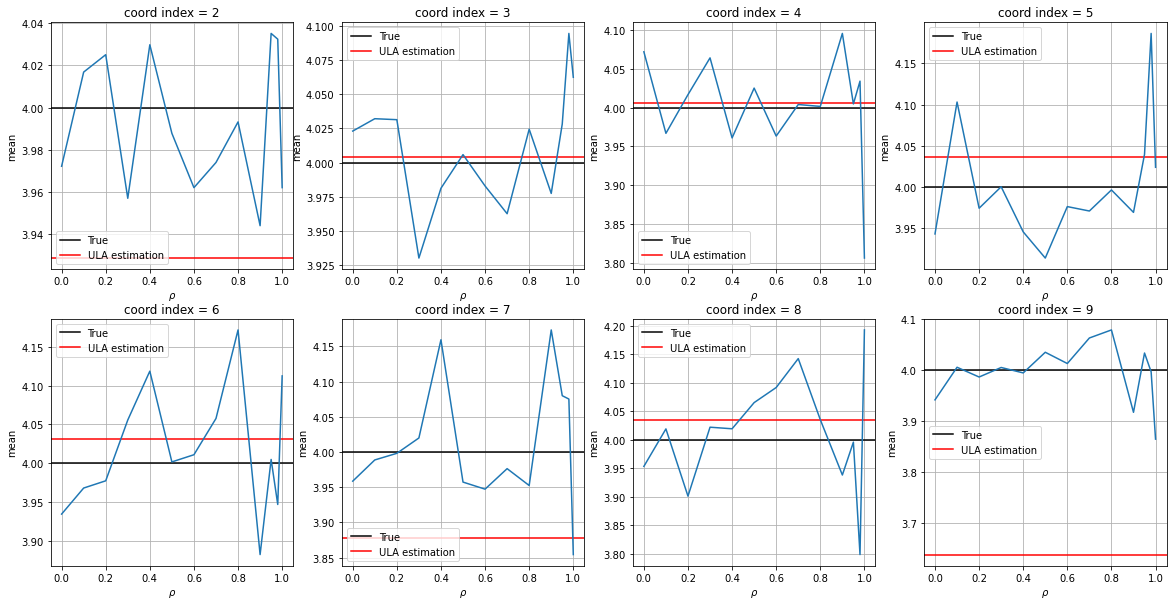

In [50]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
true_means = (locs_target).cpu().numpy()
for i in range(8):
    row = i // 4
    col = i % 4
    ind = i + 2
    
    mean_est = [mean[j][ind] for j in range(len(mean))]
    
    axs[row][col].axhline(true_means[ind], label='True', color='black')
    axs[row][col].axhline(result_mean_ula[ind], label='ULA estimation', color='red')
    axs[row][col].plot(rs, mean_est)
    axs[row][col].set_ylabel(r'mean')
    axs[row][col].set_xlabel(r'$\rho$')
    axs[row][col].grid()
    axs[row][col].set_title(f"coord index = {ind}")
    axs[row][col].legend()